# Data Collection

## import libraries

In [1]:
!pwd

/home/scuypers/GEE


In [2]:
import os
import ee
import geemap
import math

In [3]:
# run this if the token has been expired
ee.Authenticate()

Enter verification code: 4/1AdQt8qiQjinQxNHfF1o48-JIZtcFp8ErhbHcU04yIgD3qILMYqz36LEuxGc

Successfully saved authorization token.


In [3]:
ee.Initialize()

In [ ]:
# to check own Assets
# geemap.ee_search()
# conversion of entire script

Ctrl + Shift + - to split cell

In [4]:
import numpy
print(numpy.__version__) # 1.23.1
print(geemap.__version__) # 0.15.2 # 0.16.4

1.23.1
0.15.2


In [9]:
import ipyleaflet
m = ipyleaflet.Map()
m

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [ ]:
# geemap.show_youtube('RpIaalFk4H8')

## Build the map

In [5]:
Map = geemap.Map()#center=(43.708, 7.228), zoom=10)

Nice = ee.ImageCollection("users/andreanascetti/IEEE/Nice_Labels")
Map.centerObject(Nice)

palette_labels = [
  '000000',
  'FF5733', #(0)  Urban fabric
  'F98A04', #(1)  Industrial, commercial, public, military, private and transport units
  'FBDB10', #(2)  Mine, dump and construction sites
  'B7E603', #(3)  Artificial non-agricultural vegetated areas
  'B6FF45', #(4)  Arable land (annual crops)
  '5FB331', #(5)  Permanent crops
  '3FAF17', #(6)  Pastures
  'FCE5CD', #()complex and mixed...
  'C6ECB6', #()orchards at the fringe
  '237605', #(7)  Forests
  '43B680', #(8)  Herbaceous vegetation associations
  '9B621A', #(9)  Open spaces with little or no vegetation
  '0691C3', #(10)  Wetlands
  '085CB8', #(11)  Water
]

Map.addLayer(Nice,{'min':0, 'max':14, 'palette':palette_labels},"Labels_Nice")

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
print(Map.user_roi.getInfo())

In [17]:
roi_tile = ee.Geometry.Polygon(
    [[7.266985, 43.696517], [7.266985, 43.706569], [7.283252, 43.706569], [7.283252, 43.696517], [7.266985, 43.696517]]
)

In [18]:
# Add legend

legend_dict = {
  'no data':'000000',
  'Urban fabric':'FF5733', #(0)  
  'Industrial, commercial, public, military, private and transport units':'F98A04', #(1)  
  'Mine, dump and construction sites':'FBDB10', #(2)  
  'Artificial non-agricultural vegetated areas':'B7E603', #(3)  
  'Arable land (annual crops)':'B6FF45', #(4)  
  'Permanent crops':'5FB331', #(5)  
  'Pastures':'3FAF17', #(6)  
  #'complex and mixed...':'FCE5CD', #()
  #'orchards at the fringe':'C6ECB6', #()
  'Forests':'237605', #(7)  
  'Herbaceous vegetation associations':'43B680', #(8)  
  'Open spaces with little or no vegetation':'9B621A', #(9)  
  'Wetlands':'0691C3', #(10)  
  'Water':'085CB8', #(11)  
  #'Clouds & Shadow':'000000',
}

Map.add_legend(legend_title="Land cover classes", legend_dict=legend_dict)

In [19]:
# Area_Nice = Map.user_roi # json format

In [77]:
# Map.user_rois.getInfo()
Area_Nice = ee.Geometry.Polygon(
        [
            [
                [6.560201, 43.526958],
                [6.560201, 44.371294],
                [7.51888, 44.371294],
                [7.51888, 43.526958],
                [6.560201, 43.526958],
            ]
        ]
    )

## Data Collection

In [6]:
image = Nice.mosaic()

In [7]:
# random sampling
# NOT STRATIFIED
# training = image.sample(
#     **{
#         'region': Area_Nice,
#         'scale': 30,
#         'numPixels': 5000,
#         'seed': 0,
#         'geometries': True,  # Set this to False to ignore geometries
#     }
# )

In [8]:
# Map.addLayer(training, {}, 'training', True)
# Map.centerObject(Area_Nice)
# Map

Stratified sampling: 500 points per class

In [13]:
# this does not greate good points - > micro lables in between two class areas
randompoints_Nice = Nice.mosaic().stratifiedSample(
    **{
        'region': Area_Nice,
        'classBand': 'b1',
        'scale': 30,
        'numPoints': 500,
        'seed': 0,
        'geometries': True,  # Set this to False to ignore geometries
    }
)

In [14]:
palette_labels = [
  '000000',
  'FF5733', #(1)  Urban fabric
  'F98A04', #(2)  Industrial, commercial, public, military, private and transport units
  'FBDB10', #(3)  Mine, dump and construction sites
  'B7E603', #(4)  Artificial non-agricultural vegetated areas
  'B6FF45', #(5)  Arable land (annual crops)
  '5FB331', #(6)  Permanent crops
  '3FAF17', #(7)  Pastures
  'FCE5CD', #()complex and mixed...
  'C6ECB6', #()orchards at the fringe
  '237605', #(10)  Forests
  '43B680', #(11)  Herbaceous vegetation associations
  '9B621A', #(12)  Open spaces with little or no vegetation
  '0691C3', #(13)  Wetlands
  '085CB8', #(14)  Water
]

## Micro labels

In [15]:
# filter out points of class 0 and 15
randompoints_Nice = randompoints_Nice.filterMetadata("b1","not_equals", 0).filterMetadata("b1","not_equals", 15)
# create seperate featureClasses for each label
randompoints_1 = randompoints_Nice.filter(ee.Filter.eq("b1", 1))
randompoints_2 = randompoints_Nice.filter(ee.Filter.eq("b1", 2))
randompoints_3 = randompoints_Nice.filter(ee.Filter.eq("b1", 3))
randompoints_4 = randompoints_Nice.filter(ee.Filter.eq("b1", 4))
randompoints_5 = randompoints_Nice.filter(ee.Filter.eq("b1", 5))
randompoints_6 = randompoints_Nice.filter(ee.Filter.eq("b1", 6))
randompoints_7 = randompoints_Nice.filter(ee.Filter.eq("b1", 7))
randompoints_8 = randompoints_Nice.filter(ee.Filter.eq("b1", 8)) # there are points with label 8!
randompoints_10 = randompoints_Nice.filter(ee.Filter.eq("b1", 10))
randompoints_11 = randompoints_Nice.filter(ee.Filter.eq("b1", 11))
randompoints_12 = randompoints_Nice.filter(ee.Filter.eq("b1", 12))
randompoints_13 = randompoints_Nice.filter(ee.Filter.eq("b1", 13))
randompoints_14 = randompoints_Nice.filter(ee.Filter.eq("b1", 14))
# display points on map
Map = geemap.Map()
Map.centerObject(randompoints_Nice)

vis_1 = {'pointSize': 5,'color': 'FF5733'} #pointSize doesn't work
vis_2 = {'pointSize': 5,'color': 'F98A04'}
vis_3 = {'pointSize': 10,'color': 'FBDB10'}
vis_4 = {'pointSize': 10,'color': 'B7E603'}
vis_5 = {'pointSize': 5,'color': 'B6FF45'}
vis_6 = {'pointSize': 10,'color': '5FB331'}
vis_7 = {'pointSize': 5,'color': '3FAF17'}
vis_10 = {'pointSize': 5,'color': '237605'}
vis_11 = {'pointSize': 5,'color': '43B680'}
vis_12 = {'pointSize': 5,'color': '9B621A'}
vis_13 = {'pointSize': 5,'color': '0691C3'}
vis_14 = {'pointSize': 5,'color': '085CB8'}

# create sepearte mask layers for each class in the labels image
labels = Nice.mosaic()
Nice_1 = labels.updateMask(labels.eq(1))
Nice_2 = labels.updateMask(labels.eq(2))
Nice_3 = labels.updateMask(labels.eq(3))
Nice_4 = labels.updateMask(labels.eq(4))
Nice_5 = labels.updateMask(labels.eq(5))
Nice_6 = labels.updateMask(labels.eq(6))
Nice_7 = labels.updateMask(labels.eq(7))
Nice_8 = labels.updateMask(labels.eq(8))
Nice_10 = labels.updateMask(labels.eq(10))
Nice_11 = labels.updateMask(labels.eq(11))
Nice_12 = labels.updateMask(labels.eq(12))
Nice_13 = labels.updateMask(labels.eq(13))
Nice_14 = labels.updateMask(labels.eq(14))

# add masks to map

Map.addLayer(Nice.mosaic(),{'min':0, 'max':14, 'palette':palette_labels},"Labels_Nice")
# Map.addLayer(Nice_1,{'palette':['FF5733']},"Label_1")
# Map.addLayer(Nice_2,{},"Label_2")
# Map.addLayer(Nice_3,{},"Label_3")
# Map.addLayer(Nice_4,{},"Label_4")
# Map.addLayer(Nice_5,{},"Label_5")
Map.addLayer(Nice_6,{},"Label_6")
# Map.addLayer(Nice_7,{},"Label_7")
# Map.addLayer(Nice_8,{},"Label_8")

# Map.addLayer(Nice_10,{},"Label_10")
# Map.addLayer(Nice_11,{},"Label_11")
# Map.addLayer(Nice_12,{},"Label_12")
# Map.addLayer(Nice_13,{},"Label_13")
# Map.addLayer(Nice_14,{},"Label_14")

# add points to map

# Map.addLayer(randompoints_1,vis_1,'randompoints_1')
# Map.addLayer(randompoints_2,vis_2,'randompoints_2')
# Map.addLayer(randompoints_3,vis_3,'randompoints_3') # low presence
# Map.addLayer(randompoints_4,vis_4,'randompoints_4') # low presence
# Map.addLayer(randompoints_5,vis_4,'randompoints_5')
Map.addLayer(randompoints_6,vis_4,'randompoints_6') # low presence
# Map.addLayer(randompoints_7,vis_7,'randompoints_7')
# Map.addLayer(randompoints_8,vis_7,'randompoints_8')
# Map.addLayer(randompoints_10,vis_10,'randompoints_10')
# Map.addLayer(randompoints_11,vis_11,'randompoints_11')
# Map.addLayer(randompoints_12,vis_12,'randompoints_12')
# Map.addLayer(randompoints_13,vis_13,'randompoints_13') # wetlands
# Map.addLayer(randompoints_14,vis_14,'randompoints_14')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
# Add legend

legend_dict_low_presence = {
 
  '3 Mine, dump and construction sites':'FBDB10', 
  '4 Artificial non-agricultural vegetated areas':'B7E603', 
    
  '5 Arable land (annual crops)':'B6FF45',
  '6 ermanent crops':'5FB331', 
  '7 Pastures':'3FAF17', 

}

Map.add_legend(legend_title="Land cover classes", legend_dict=legend_dict_low_presence)

In [ ]:
# split samples in training/validation

randompoints_Nice = randompoints_Nice.randomColumn();

# split in a training (80%) and validation (20%)
training = randompoints_Nice.filter(ee.Filter.gt('random',0.2)); # random value greater than
validation = randompoints_Nice.filter(ee.Filter.lte('random',0.2)); # random value less or equal to

## Saving Data

Saving as shapefile to server.

In [ ]:
# saving training points as shapefile
geemap.ee_to_shp(training, filename='/home/scuypers/GEE/outputs/training.shp')

In [ ]:
# saving validation points as shapefile
geemap.ee_to_shp(validation, filename='/home/scuypers/GEE/outputs/validation.shp')

Saving as asset to GEE platform

In [ ]:
task = ee.batch.Export.table.toAsset(
    collection=training,
    description='training data nice from jupyter notebook',
    assetId='users/suzannacuypers/EARSeL/trainingData_Nice_14')

task.start()

In [ ]:
task = ee.batch.Export.table.toAsset(
    collection=validation,
    description='validation data nice from jupyter notebook',
    assetId='users/suzannacuypers/EARSeL/validationData_Nice_14')

task.start()

## Relaoding saved files

Loading previously generated training/validation points from server (shapefiles)

In [ ]:
# import shapefiles
# training_shp = '/home/scuypers/GEE/outputs/training.shp'
# training = geemap.shp_to_ee(training_shp)

# validation_shp = '/home/scuypers/GEE/outputs/validation.shp'
# validation = geemap.shp_to_ee(validation_shp)

Loading previously generated training/validation points from GEE Assets

In [ ]:
# import assets
training = ee.FeatureCollection('users/suzannacuypers/EARSeL/trainingData_Nice_new')
validation = ee.FeatureCollection('users/suzannacuypers/EARSeL/validationData_Nice_new')

Visualize training points on map

In [ ]:
vis_params = {
    #'color':'006633' # white 'E5FFCC', # green
    'pointSize':3
}
Map.addLayer(training,vis_params,'training points')
Map

# Composite

In [246]:
period_of_interest = ee.Filter.date('2017-01-01', '2019-12-31')
inBands = ["B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12"]
outBands = inBands.copy() ### THIS IS THE REASON OF THE ERRORS
newBands = ["NDVI","NDVI_STD","BSI"]
print(inBands,outBands)
outBands.extend(newBands)
print(inBands,outBands)

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'] ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'] ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'NDVI_STD', 'BSI']


In [247]:
# This is the cloud masking function provided by GEE but adapted for use in Python.
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10 # 1024
    cirrusBitMask = 1 << 11 # 2048

    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0)
    mask = mask.bitwiseAnd(cirrusBitMask).eq(0)
    
    helper = image.updateMask(mask).divide(10000)
    helper = ee.Image(helper.copyProperties(image, properties=["system:time_start"]))
    #ee.Image(helper.copyProperties(image, properties=["CLOUD_COVERAGE_PERCENTAGE"]))

    return helper

In [248]:
dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR') 
    .filterBounds(Area_Nice)
    .filter(period_of_interest)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)) 
    .map(maskS2clouds)
    .select(inBands)#.select(["B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12"])#.select('B2')
)
# print(dataset.first().propertyNames().getInfo())
# median = dataset.select(['B5','B4', 'B3', 'B2']).median()

# median = dataset.select(["B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12"]).median()

median = dataset.median()

visParams = {
    'bands': ['B4', 'B3', 'B2'],#'B4', 'B3', 'B2'],
    'min': 0,
    'max': 0.3,
}

Map = geemap.Map()
Map.centerObject(Area_Nice)
Map.addLayer(median, visParams,'median')#{'bands':['B4', 'B3', 'B2']}, 'Median')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
# print(dataset.propertyNames().getInfo())

# image = dataset.first()
# print(image.propertyNames().getInfo())
# print(image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo())

In [24]:
# number of images (size)
print(dataset.size().getInfo()) # 355

355


## Vegetation indices

In [249]:
#Add NDVI and BSI spectral indices
def addNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']) \
    .rename('NDVI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(ndvi)

def addBSI(image):
    bsi = image.expression(
    '((RED + SWIR) - (NIR + BLUE)) / ((RED + SWIR) + (NIR + BLUE)) ',
    {
    'RED': image.select('B4'),
    'BLUE': image.select('B2'),
    'NIR': image.select('B8'),
    'SWIR': image.select('B11'),
    }
    ) \
    .rename('BSI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(bsi)

def addEVI(image):
    evi = image.expression(
    '(2.5 * (NIR - RED)) / (NIR + 6 * RED - 7.5 * BLUE + 1) ',
    {
    'RED': image.select('B4'),
    'BLUE': image.select('B2'),
    'NIR': image.select('B8'),
    'G': 2.5,
    'C1': 6,
    'C2': 7.5,
    'L': 1,
    }
    ) \
    .rename('EVI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(evi)

def addGRVI(image):
    grvi = image.expression(
    '(GREEN - RED) / (RED + GREEN) ',
    {
    'RED': image.select('B4'),
    'GREEN': image.select('B3'),
    }
    ) \
    .rename('GRVI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(grvi)

def addMNDWI(image):
    mndwi = image.expression(
    '(GREEN - SWIR) / (GREEN + SWIR) ',
    {
    'GREEN': image.select('B3'),
    'SWIR': image.select('B11'),
    }
    ) \
    .rename('MNDWI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(mndwi)

def addSMMI(image):
    smmi = image.expression(
    '(sqrt((NIR + SWIR) / 2)) ',
    {
    'NIR': image.select('B8'),
    'SWIR': image.select('B11'),
    }
    ) \
    .rename('SMMI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(smmi)

def addNMDI(image):
    nmdi = image.expression(
    '(NIR - (SWIR11 - SWIR12)) / (NIR + (SWIR11 - SWIR12)) ',
    {
    'NIR': image.select('B8'),
    'SWIR11': image.select('B11'),
    'SWIR12': image.select('B12'),
    }
    ) \
    .rename('NMDI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(nmdi)

def addNDBI(image):
    ndbi = image.expression(
    '( SWIR - NIR ) / ( SWIR + NIR ) ',
    {
    'NIR': image.select('B8'),
    'SWIR': image.select('B11'),
    }
    ) \
    .rename('NDBI') \
    .copyProperties(image,['system:time_start'])
    return image.addBands(ndbi)

In [250]:
#Collection with all images also containing the NDVI and BSI indices
collection = dataset.select(inBands).map(addNDVI).map(addBSI)\
     .map(addEVI).map(addGRVI).map(addMNDWI).map(addSMMI).map(addNMDI).map(addNDBI)
# print(collection.propertyNames().getInfo())
print(collection.first().bandNames().getInfo())

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'BSI', 'EVI', 'GRVI', 'MNDWI', 'SMMI', 'NMDI', 'NDBI']


Show NDVI on the map.

In [251]:
### Map NDVI
# Convert the image collection to an image.
image = collection.select('NDVI').median()
#print(image.bandNames()) # ee.List object

NDVIpalette = ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901', '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01', '012E01', '011D01', '011301']
Map.addLayer(image, {'palette': NDVIpalette},'NDVI median')#{'bands':['B4', 'B3', 'B2']}, 'Median')
Map

Map(bottom=47986.0, center=[43.94962715775877, 7.0395405], controls=(WidgetControl(options=['position', 'trans…

## Create median Image

In [252]:
# Define and calculate the median bands and the other index statistics
print(inBands)
band_median = collection.select(inBands).median() # one image

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']


In [253]:
# one image each
ndvimax = collection.select('NDVI').reduce(ee.Reducer.max()).rename("NDVI_MAX")
ndvimean = collection.select('NDVI').reduce(ee.Reducer.mean()).rename("NDVI")
ndvistd = collection.select('NDVI').reduce(ee.Reducer.stdDev()).float().rename("NDVI_STD")

nmdimax = collection.select('NMDI').reduce(ee.Reducer.max()).rename("NMDI_MAX")
nmdimean = collection.select('NMDI').reduce(ee.Reducer.mean()).rename("NMDI")
nmdistd = collection.select('NMDI').reduce(ee.Reducer.stdDev()).float().rename("NMDI_STD")

ndbimax = collection.select('NDBI').reduce(ee.Reducer.max()).rename("NDBI_MAX")
ndbimean = collection.select('NDBI').reduce(ee.Reducer.mean()).rename("NDBI")
ndbistd = collection.select('NDBI').reduce(ee.Reducer.stdDev()).float().rename("NDBI_STD")

bsimax = collection.select('BSI').reduce(ee.Reducer.max()).rename("BSI_MAX")
bsimean = collection.select('BSI').reduce(ee.Reducer.mean()).rename("BSI")
bsistd = collection.select('BSI').reduce(ee.Reducer.stdDev()).float().rename("BSI_STD")

evimax = collection.select('EVI').reduce(ee.Reducer.max()).rename("EVI_MAX")
evimean = collection.select('EVI').reduce(ee.Reducer.mean()).rename("EVI")
evistd = collection.select('EVI').reduce(ee.Reducer.stdDev()).float().rename("EVI_STD")

grvimax = collection.select('GRVI').reduce(ee.Reducer.max()).rename("GRVI_MAX")
grvimean = collection.select('GRVI').reduce(ee.Reducer.mean()).rename("GRVI")
grvistd = collection.select('GRVI').reduce(ee.Reducer.stdDev()).float().rename("GRVI_STD")

mndwimax = collection.select('MNDWI').reduce(ee.Reducer.max()).rename("MNDWI_MAX")
mndwimean = collection.select('MNDWI').reduce(ee.Reducer.mean()).rename("MNDWI")
mndwistd = collection.select('MNDWI').reduce(ee.Reducer.stdDev()).float().rename("MNDWI_STD")

smmimax = collection.select('SMMI').reduce(ee.Reducer.max()).rename("SMMI_MAX") # soil monitoring moisture index
smmimean = collection.select('SMMI').reduce(ee.Reducer.mean()).rename("SMMI")
smmistd = collection.select('SMMI').reduce(ee.Reducer.stdDev()).float().rename("SMMI_STD")

In [254]:
#Add the index statistics to the median bands and clip the dataset with the ROI
# one image adding bands
compclip = band_median.addBands(ndvimax).addBands(ndvimean).addBands(ndvistd) \
    .addBands(nmdimax).addBands(nmdimean).addBands(nmdistd) \
    .addBands(ndbimax).addBands(ndbimean).addBands(ndbistd) \
    .addBands(bsimax).addBands(bsimean).addBands(bsistd) \
    .addBands(evimax).addBands(evimean).addBands(evistd) \
    .addBands(grvimax).addBands(grvimean).addBands(grvistd) \
    .addBands(mndwimax).addBands(mndwimean).addBands(mndwistd) \
    .addBands(smmimax).addBands(smmimean).addBands(smmistd) \
    .clip(Area_Nice)

In [255]:
OutBands  = ["B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12",
             "NDVI_MAX","NDVI","NDVI_STD",
             "NMDI","NMDI_MAX","NMDI_STD",
             "NDBI","NDBI_MAX","NDBI_STD",
             "BSI","BSI_MAX","BSI_STD",
             "EVI","EVI_MAX","EVI_STD",
             "GRVI","GRVI_MAX","GRVI_STD",
             "MNDWI","MNDWI_MAX","MNDWI_STD",
             "SMMI","SMMI_MAX","SMMI_STD"
            ]

## Temporal analysis

For the temporal analysis we need the variables time and a constant added to each image.

In [256]:
# test is timefield is present (added in masks2cloud function)
timeField = 'system:time_start'
first = collection.first()
print(first.propertyNames().getInfo())

['system:time_start', 'system:index', 'system:bands', 'system:band_names']


In [257]:
timeField = 'system:time_start'
# Use this function to add variables for NDVI, time and a constant to Sentinel 2 imagery.
def addVariables(image):
    # Compute time in fractional years since the epoch.
    date = ee.Date(image.get(timeField))
    years = date.difference(ee.Date('2017-01-01'), 'year')
    # Return the image with the added bands.
    return image.addBands(ee.Image(years).rename('t')) \
                .float() \
                .addBands(ee.Image.constant(1))

In [258]:
# add variables to the images in the collection
collection = collection.map(addVariables)

In [259]:
# test if the new bands are added to the images
first = collection.first()
print(first.bandNames().getInfo())

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'BSI', 'EVI', 'GRVI', 'MNDWI', 'SMMI', 'NMDI', 'NDBI', 't', 'constant']


### NDVI

In [332]:
# List of the independent variable names
independents = ee.List(['constant', 't']) # constant + t * x

# Name of the dependent variable.
dependent = ee.String('NDVI') # NDVI = constant + t * x
# Compute a linear trend.  This will have two bands: 'residuals' and
# a 2x1 band called coefficients (columns are for dependent variables).

# per pixel estimating a line to model the time variation

trend = collection.select(independents.add(dependent)) \
  .reduce(ee.Reducer.linearRegression(independents.length(), 1)) # ee.Reducer.linearRegression(numX, numY) # numX	Integer	The number of input dimensions.
# result is 2 bands: ['coefficients', 'residuals']

In [333]:
print(trend.bandNames().getInfo())

['coefficients', 'residuals']


In [334]:
# Flatten the coefficients into a 2-band image, named constant and t
coefficients = trend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([independents])
# 2 coefficients = constant (b) and coefficient of time t (a*x)
Map = geemap.Map()
Map.centerObject(Area_Nice)

visParams = {
    'bands': ['B4', 'B3', 'B2'],#'B4', 'B3', 'B2'],
    'min': 0,
    'max': 0.3,
}

Map.addLayer(median, visParams,'median')#{'bands':['B4', 'B3', 'B2']}, 'Median')
### constant:
# mean NDVI over time # white = strong vegetation
# dark pixels = no vegetation
vis_params_c = {'bands': ['constant'], 'min': 0, 'max': 1,'opacity': 1.0, 'gamma': 1.0} 
Map.addLayer(ee.Image(coefficients),vis_params_c,'constant')
### t:
# time: white = NDVI growing, black = NDVI going down
vis_params_t = {'bands': ['t'], 'min': -0.05, 'max': 0.05,'opacity': 1.0, 'gamma': 1.0} 
Map.addLayer(ee.Image(coefficients),vis_params_t,'time coefficient')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
# draw feature on map for roi
# roi = Map.user_roi 
# print(roi.getInfo())

In [ ]:
# Map.user_rois.getInfo()

In [335]:
# small roi for chart
roi_baresoil = ee.Geometry.Polygon([[[7.413165, 43.796859], [7.413165, 43.797936], [7.415505, 43.797936], [7.415505, 43.796859], [7.413165, 43.796859]]])
roi_vegetation = ee.Geometry.Polygon([[[7.290191, 43.777612], [7.290191, 43.778333], [7.291779, 43.778333], [7.291779, 43.777612], [7.290191, 43.777612]]])
roi_building = ee.Geometry.Polygon([[[7.283828, 43.706344], [7.283828, 43.70684], [7.284708, 43.70684], [7.284708, 43.706344], [7.283828, 43.706344]]])
roi_water = ee.Geometry.Polygon([[[7.260593, 43.666558], [7.260593, 43.669166], [7.26437, 43.669166], [7.26437, 43.666558], [7.260593, 43.666558]]])

In [336]:
# Compute a detrended series.
def func_qwf(image):
    return image.select(dependent).subtract(
                image.select(independents).multiply(coefficients).reduce('sum')) \
                .rename(dependent) \
                .copyProperties(image, ['system:time_start'])

print(dependent.getInfo()) # NDVI

detrended = collection.map(func_qwf) # NDVI = select dependent, subtract [sum(independent*coefficients)]

first = detrended.first()
print(first.bandNames().getInfo()) # NDVI

NDVI
['NDVI']


Plot the detrended Sentinel time series at a specific roi.

In [337]:
def index_area(detrended, index, roi):
    index_series = detrended.filterBounds(roi).select(index).toBands()
    index_values = index_series.reduceRegion(ee.Reducer.mean(), roi , 30)
    data = index_values.getInfo() # dictionary with keys = timestamps, values = NDVI
    return data

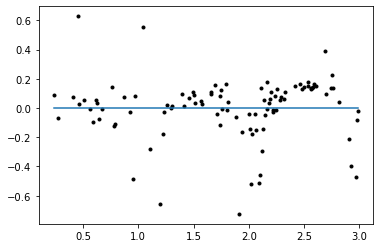

In [338]:
from matplotlib import pyplot as plt
import numpy as np

# roi_water
data = index_area(detrended, 'NDVI', roi_water)
time = index_area(collection,'t', roi_water)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')

x = range(len(data.items()))
a, b = np.polyfit(list(time.values()), list(data.values()), 1)
plt.plot(list(time.values()), a*x+b) 

plt.show()

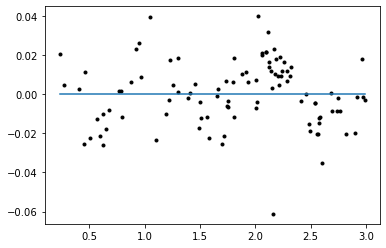

In [280]:
# roi_building
data = index_area(detrended, 'NDVI', roi_building)
time = index_area(collection,'t', roi_building)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')

x = range(len(data.items()))
a, b = np.polyfit(list(time.values()), list(data.values()), 1)
plt.plot(list(time.values()), a*x+b) 

plt.show()

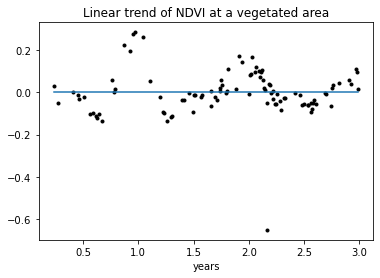

In [286]:
# roi_vegetation
data = index_area(detrended, 'NDVI', roi_vegetation)
time = index_area(collection,'t', roi_vegetation)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')

x = range(len(data.items()))
a, b = np.polyfit(list(time.values()), list(data.values()), 1)
plt.plot(list(time.values()), a*x+b)  

plt.title('Linear trend of NDVI at a vegetated area')
plt.xlabel('years')

plt.show()

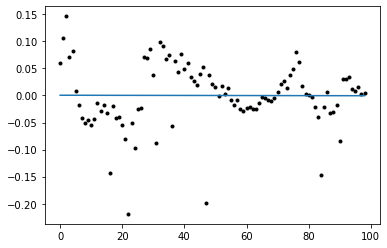

In [44]:
# roi_baresoil
data = index_area(detrended, 'NDVI', roi_baresoil)
plt.plot(list(data.values()),  '.', color='black')

x = range(len(data.items()))
a, b = np.polyfit(list(time.values()), list(data.values()), 1)
plt.plot(list(time.values()), a*x+b) 

plt.show()

Harmonic regression

In [339]:
# Use these independent variables in the harmonic regression.
harmonicIndependents = ee.List(['constant', 't', 'cos', 'sin'])

In [340]:
firsta = collection.first()
print(firsta.bandNames().getInfo())

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'BSI', 'EVI', 'GRVI', 'MNDWI', 'SMMI', 'NMDI', 'NDBI', 't', 'constant']


In [341]:
# Add harmonic terms as new image bands.

def func_cow(image):
    timeRadians = image.select('t').multiply(2 * math.pi)
    return image \
          .addBands(timeRadians.cos().rename('cos')) \
          .addBands(timeRadians.sin().rename('sin'))

harmonicLandsat = collection.map(func_cow)

harmonicTrend = harmonicLandsat.select(harmonicIndependents.add(dependent)) \
    .reduce(ee.Reducer.linearRegression(
    **{
    'numX': harmonicIndependents.length(),
    'numY': 1
    }))

In [342]:
# Turn the array image into a multi-band image of coefficients.
harmonicTrendCoefficients = harmonicTrend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([harmonicIndependents])

# coefficient of time t (a*x), constant (b), c*cos(2*pi*t), d*sin(2*pi*t)
Map = geemap.Map()
Map.centerObject(Area_Nice)
### constant:
# mean NDVI over time # white = strong vegetation
# dark pixels = no vegetation
vis_params_c = {'bands': ['constant'], 'min': 0, 'max': 1,'opacity': 1.0, 'gamma': 1.0} 
Map.addLayer(ee.Image(harmonicTrendCoefficients),vis_params_c,'constant')
### t:
# time: white = NDVI growing, black = NDVI going down
vis_params_t = {'bands': ['t'], 'min': -0.05, 'max': 0.05,'opacity': 1.0, 'gamma': 1.0} 
Map.addLayer(ee.Image(harmonicTrendCoefficients),vis_params_t,'time coefficient')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [343]:
# Compute fitted values.

def func_qam(image):
    return image.addBands(
          image.select(harmonicIndependents) \
            .multiply(harmonicTrendCoefficients) \
            .reduce('sum') \
            .rename('fitted'))

fittedHarmonic = harmonicLandsat.map(func_qam)

In [344]:
print(harmonicLandsat.first().bandNames().getInfo())

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI', 'BSI', 'EVI', 'GRVI', 'MNDWI', 'SMMI', 'NMDI', 'NDBI', 't', 'constant', 'cos', 'sin']


In [345]:
def harmonic_index_area(fittedHarmonic,index, roi):
    index_series = fittedHarmonic.filterBounds(roi).select([index]).toBands() # is an image
    index_values = index_series.reduceRegion(ee.Reducer.mean(), roi , 30)
    data = index_values.getInfo() # dictionary with keys = timestamps, values = NDVI
    return data

In [346]:
def objective(x, constant, t, cos, sin): # x = timestamp/range, output = predicted index value
    return t*x + cos*math.cos(2*math.pi*x) + sin*math.sin(2*math.pi*x) + constant

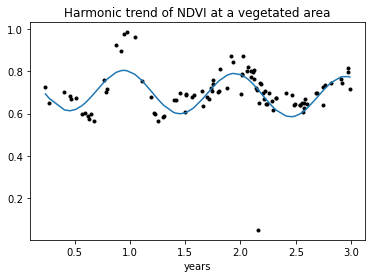

In [347]:
# roi_vegetation
data = harmonic_index_area(fittedHarmonic, 'NDVI', roi_vegetation)
time = harmonic_index_area(fittedHarmonic,'t',roi_vegetation)
# print(time)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')
# plt.plot(list(data.values()),  '.', color='black')

data = harmonic_index_area(fittedHarmonic, 'fitted', roi_vegetation)
plt.plot(list(time.values()),list(data.values()))

plt.title('Harmonic trend of NDVI at a vegetated area')
plt.xlabel('years')

plt.show()

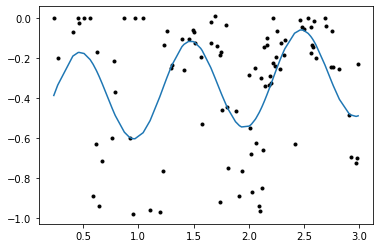

In [63]:
# harmonic at point
point_water = ee.Geometry.Point([7.225149, 43.654973])

data = harmonic_index_area(fittedHarmonic, 'NDVI', point_water)
time = harmonic_index_area(fittedHarmonic,'t',point_water)

plt.plot(list(time.values()),list(data.values()),  '.', color='black')
# plt.plot(list(data.values()))

data = harmonic_index_area(fittedHarmonic, 'fitted', point_water)
# plt.plot(list(data.values()),  '.', color='black')
plt.plot(list(time.values()),list(data.values()))
plt.show()

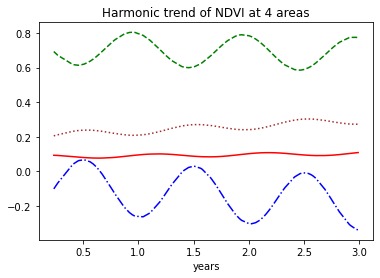

In [354]:
# compare harmonics at different areas
data_V = harmonic_index_area(fittedHarmonic, 'fitted', roi_vegetation)
data_BS = harmonic_index_area(fittedHarmonic, 'fitted', roi_baresoil)
data_W = harmonic_index_area(fittedHarmonic, 'fitted', roi_water)
data_B = harmonic_index_area(fittedHarmonic, 'fitted', roi_building)
time = harmonic_index_area(fittedHarmonic,'t',roi_vegetation)

plt.plot(list(time.values()),list(data_V.values()),'g--')
plt.plot(list(time.values()),list(data_BS.values()),':',color = 'brown')
plt.plot(list(time.values()),list(data_W.values()),'b-.')
plt.plot(list(time.values()),list(data_B.values()),color = 'red')

plt.title('Harmonic trend of NDVI at 4 areas')
plt.xlabel('years')

plt.show()

In [64]:
print(fittedHarmonic.mean().clip(point_water).select('cos').getInfo())

{'type': 'Image', 'bands': [{'id': 'cos', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [1, 1], 'origin': [7, 43], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:footprint': {'type': 'Point', 'coordinates': [7.225149, 43.654973]}}}


In [65]:
out_stats = '/home/scuypers/GEE/outputs/stats.csv'

# Extract and export zonal statistics
# geemap.zonal_statistics(fittedHarmonic, ee.FeatureCollection(point_water), out_stats, statistics_type='MEAN', scale=10)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /home/scuypers/GEE/outputs/stats.csv


In [70]:
# Compute phase and amplitude.
phase_ndvi = harmonicTrendCoefficients.select('sin') \
  .atan2(harmonicTrendCoefficients.select('cos')) \
  .unitScale(-math.pi, math.pi) \
  .rename("HUE_NDVI")

amplitude_ndvi = harmonicTrendCoefficients.select('sin') \
  .hypot(harmonicTrendCoefficients.select('cos')) \
  .multiply(5) \
  .rename("SAT_NDVI")

# Compute the mean NDVI.
meanNdvi= collection.select('NDVI').mean().rename("VAL_NDVI")

# Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
    phase_ndvi,      # hue
    amplitude_ndvi,  # saturation (difference from white)
    meanNdvi    # value (difference from black)
    ]).hsvToRgb()

Add to map

In [71]:
Map.addLayer(rgb, {}, 'phase_ndvi (hue), amplitude_ndvi (sat), ndvi (val')
Map

Map(center=[43.94962715775877, 7.0395405], controls=(WidgetControl(options=['position', 'transparent_bg'], wid…

### NMDI

The Normalized Multi-band Drought Index (NMDI) is used for monitoring soil and vegetation moisture from space.

In [355]:
# List of the independent variable names
independents = ee.List(['constant', 't'])

# Name of the dependent variable.
dependent = ee.String('NMDI')

# Compute a linear trend.  This will have two bands: 'residuals' and
# a 2x1 band called coefficients (columns are for dependent variables).
trend = collection.select(independents.add(dependent)) \
  .reduce(ee.Reducer.linearRegression(independents.length(), 1))
# Map.addLayer(trend, {}, 'trend array image')

# Flatten the coefficients into a 2-band image
coefficients = trend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([independents])

In [356]:
# Compute a de-trended series.
def func_dcf(image):
    return image.select(dependent).subtract(
                image.select(independents).multiply(coefficients).reduce('sum')) \
                .rename(dependent) \
                .copyProperties(image, ['system:time_start'])

detrended = collection.map(func_dcf)

Plot the detrended results.

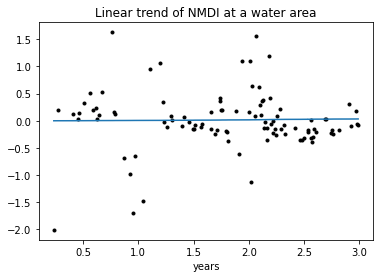

In [291]:
# roi_water
data = index_area(detrended, 'NMDI',roi_water)
time = index_area(collection,'t', roi_water)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')

x = range(len(data.items()))
a, b = np.polyfit(list(time.values()), list(data.values()), 1)
plt.plot(list(time.values()), a*x+b) 

plt.title('Linear trend of NMDI at a water area')
plt.xlabel('years')

plt.show()

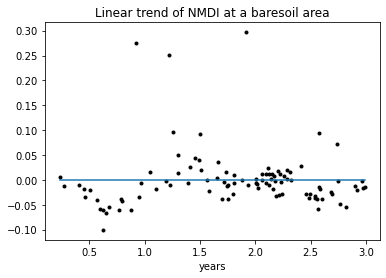

In [292]:
# roi_baresoil
data = index_area(detrended, 'NMDI',roi_baresoil)
time = index_area(collection,'t', roi_baresoil)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')

x = range(len(data.items()))
a, b = np.polyfit(list(time.values()), list(data.values()), 1)
plt.plot(list(time.values()), a*x+b) 

plt.title('Linear trend of NMDI at a baresoil area')
plt.xlabel('years')

plt.show()

In [ ]:
# Plot the detrended results.
# detrendedChart = ui.Chart.image.series(detrended, roi, None, 30) \
#   .setOptions({
#     'title': 'Detrended Sentinel time series at ROI',
#     'lineWidth': 1,
#     'pointSize': 3,
#   })
#print(detrendedChart)

Harmonic regression.

In [357]:
# Use these independent variables in the harmonic regression.
harmonicIndependents = ee.List(['constant', 't', 'cos', 'sin'])

In [358]:
# Add harmonic terms as new image bands.

def func_mwh(image):
    timeRadians = image.select('t').multiply(2 * math.pi)
    return image \
          .addBands(timeRadians.cos().rename('cos')) \
          .addBands(timeRadians.sin().rename('sin'))

harmonicLandsat = collection.map(func_mwh)

harmonicTrend = harmonicLandsat \
.select(harmonicIndependents.add(dependent)) \
.reduce(ee.Reducer.linearRegression(
    **{
        'numX': harmonicIndependents.length(),
        'numY': 1
    }))
# Turn the array image into a multi-band image of coefficients.
harmonicTrendCoefficients = harmonicTrend.select('coefficients') \
.arrayProject([0]) \
.arrayFlatten([harmonicIndependents])

In [359]:
# Compute fitted values.

def func_hoj(image):
    return image.addBands(
          image.select(harmonicIndependents) \
            .multiply(harmonicTrendCoefficients) \
            .reduce('sum') \
            .rename('fitted'))

fittedHarmonic = harmonicLandsat.map(func_hoj)

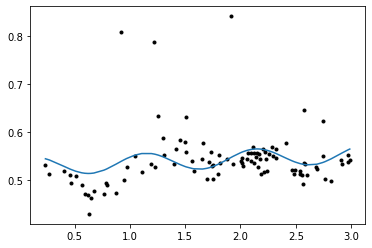

In [360]:
# roi_baresoil
data = harmonic_index_area(fittedHarmonic, 'NMDI', roi_baresoil)
time = harmonic_index_area(fittedHarmonic,'t',roi_baresoil)
# print(time)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')
# plt.plot(list(data.values()),  '.', color='black')

data = harmonic_index_area(fittedHarmonic, 'fitted', roi_baresoil)
plt.plot(list(time.values()),list(data.values()))


plt.show()

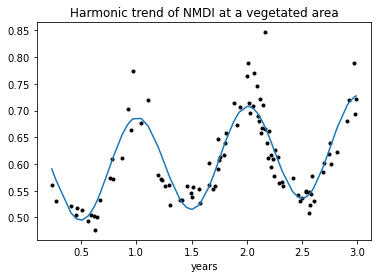

In [297]:
# roi_vegetation
data = harmonic_index_area(fittedHarmonic, 'NMDI',roi_vegetation)
time = harmonic_index_area(fittedHarmonic,'t',roi_vegetation)

plt.plot(list(time.values()),list(data.values()),  '.', color='black')

data = harmonic_index_area(fittedHarmonic, 'fitted', roi_vegetation)
plt.plot(list(time.values()),list(data.values()))

plt.title('Harmonic trend of NMDI at a vegetated area')
plt.xlabel('years')

plt.show()

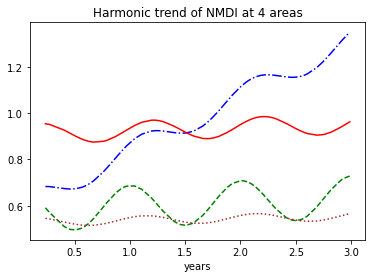

In [361]:
# compare harmonics at different areas
data_V = harmonic_index_area(fittedHarmonic, 'fitted', roi_vegetation)
data_BS = harmonic_index_area(fittedHarmonic, 'fitted', roi_baresoil)
data_W = harmonic_index_area(fittedHarmonic, 'fitted', roi_water)
data_B = harmonic_index_area(fittedHarmonic, 'fitted', roi_building)
time = harmonic_index_area(fittedHarmonic,'t',roi_vegetation)

plt.plot(list(time.values()),list(data_V.values()),'g--')
plt.plot(list(time.values()),list(data_BS.values()),':',color = 'brown')
plt.plot(list(time.values()),list(data_W.values()),'b-.')
plt.plot(list(time.values()),list(data_B.values()),color = 'red')

plt.title('Harmonic trend of NMDI at 4 areas')
plt.xlabel('years')

plt.show()

In [ ]:
# Plot the fitted model and the original data at the ROI.
#print(ui.Chart.image.series(
# fittedHarmonic.select(['fitted','NMDI']), roi, ee.Reducer.mean(), 30) \
#   .setSeriesNames(['NMDI', 'fitted']) \
#   .setOptions({
#     'title': 'Harmonic model: original and fitted values',
#     'lineWidth': 1,
#     'pointSize': 3,
# }))

In [ ]:
# Compute phase and amplitude.
phase_nmdi = harmonicTrendCoefficients.select('sin') \
  .atan2(harmonicTrendCoefficients.select('cos')) \
  .unitScale(-math.pi, math.pi) \
  .rename("HUE_NMDI")

amplitude_nmdi = harmonicTrendCoefficients.select('sin') \
  .hypot(harmonicTrendCoefficients.select('cos')) \
  .multiply(5) \
  .rename("SAT_NMDI")

# Compute the mean NDVI.
meanNmdi= collection.select('NMDI').mean().rename("VAL_NMDI")

# Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
    phase_nmdi,      # hue
    amplitude_nmdi,  # saturation (difference from white)
    meanNmdi    # value (difference from black)
]).hsvToRgb()

Add to map

In [ ]:
Map.addLayer(rgb, {}, 'phase_nmdi (hue), amplitude_nmdi (sat), nmdi (val')
Map

### NDBI

The Normalized Difference Built-up Index (NDBI) uses the NIR and SWIR bands to emphasize manufactured built-up areas.

In [362]:
# List of the independent variable names
independents = ee.List(['constant', 't'])

# Name of the dependent variable.
dependent = ee.String('NDBI')

# Compute a linear trend.  This will have two bands: 'residuals' and
# a 2x1 band called coefficients (columns are for dependent variables).
trend = collection.select(independents.add(dependent)) \
  .reduce(ee.Reducer.linearRegression(independents.length(), 1))
# Map.addLayer(trend, {}, 'trend array image')

# Flatten the coefficients into a 2-band image
coefficients = trend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([independents])

In [363]:
# Compute a de-trended series.

def func_szc(image):
    return image.select(dependent).subtract(
                image.select(independents).multiply(coefficients).reduce('sum')) \
                .rename(dependent) \
                .copyProperties(image, ['system:time_start'])

detrended = collection.map(func_szc)

Detrended chart.

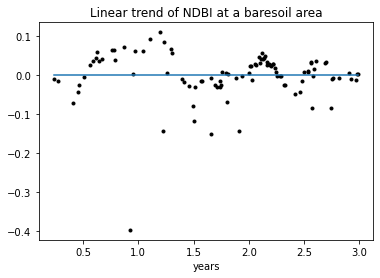

In [300]:
# roi_baresoil
data = index_area(detrended, 'NDBI',roi_baresoil)
time = index_area(collection,'t', roi_baresoil)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')

x = range(len(data.items()))
a, b = np.polyfit(list(time.values()), list(data.values()), 1)
plt.plot(list(time.values()), a*x+b) 

plt.title('Linear trend of NDBI at a baresoil area')
plt.xlabel('years')

plt.show()

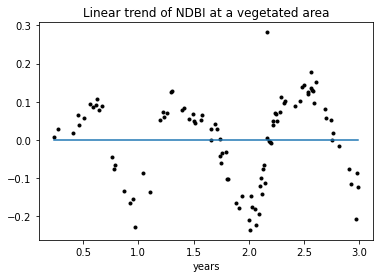

In [306]:
# roi_vegetation
data = index_area(detrended, 'NDBI',roi_vegetation)
time = index_area(collection,'t', roi_vegetation)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')

x = range(len(data.items()))
a, b = np.polyfit(list(time.values()), list(data.values()), 1)
plt.plot(list(time.values()), a*x+b) 

plt.title('Linear trend of NDBI at a vegetated area')
plt.xlabel('years')

plt.show()

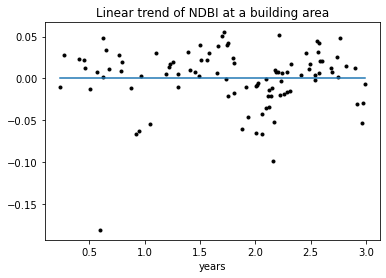

In [301]:
# roi_building
data = index_area(detrended, 'NDBI',roi_building)
time = index_area(collection,'t', roi_building)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')

x = range(len(data.items()))
a, b = np.polyfit(list(time.values()), list(data.values()), 1)
plt.plot(list(time.values()), a*x+b) 

plt.title('Linear trend of NDBI at a building area')
plt.xlabel('years')

plt.show()

In [ ]:
# Plot the detrended results.
# detrendedChart = ui.Chart.image.series(detrended, roi, None, 30) \
#   .setOptions({
#     'title': 'Detrended Sentinel time series at ROI',
#     'lineWidth': 1,
#     'pointSize': 3,
#   })
#print(detrendedChart)

In [364]:
# Use these independent variables in the harmonic regression.
harmonicIndependents = ee.List(['constant', 't', 'cos', 'sin'])

In [365]:
# Add harmonic terms as new image bands.

def func_ynp(image):
    timeRadians = image.select('t').multiply(2 * math.pi)
    return image \
          .addBands(timeRadians.cos().rename('cos')) \
          .addBands(timeRadians.sin().rename('sin'))

harmonicLandsat = collection.map(func_ynp)

harmonicTrend = harmonicLandsat \
    .select(harmonicIndependents.add(dependent)) \
    .reduce(ee.Reducer.linearRegression(
        **{
            'numX': harmonicIndependents.length(),
            'numY': 1
        }))
# Turn the array image into a multi-band image of coefficients.
harmonicTrendCoefficients = harmonicTrend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([harmonicIndependents])

In [366]:
# Compute fitted values.

def func_coj(image):
    return image.addBands(
          image.select(harmonicIndependents) \
            .multiply(harmonicTrendCoefficients) \
            .reduce('sum') \
            .rename('fitted'))

fittedHarmonic = harmonicLandsat.map(func_coj)

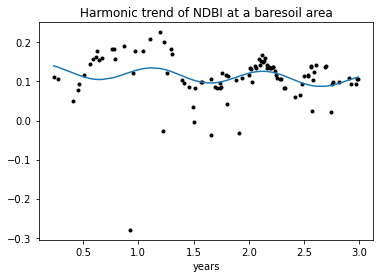

In [367]:
# roi_baresoil
data = harmonic_index_area(fittedHarmonic, 'NDBI',roi_baresoil)
time = harmonic_index_area(fittedHarmonic,'t',roi_baresoil)

plt.plot(list(time.values()),list(data.values()),  '.', color='black')
# plt.plot(list(data.values()))

data = harmonic_index_area(fittedHarmonic, 'fitted', roi_baresoil)
# plt.plot(list(data.values()),  '.', color='black')
plt.plot(list(time.values()),list(data.values()))

plt.title('Harmonic trend of NDBI at a baresoil area')
plt.xlabel('years')

plt.show()

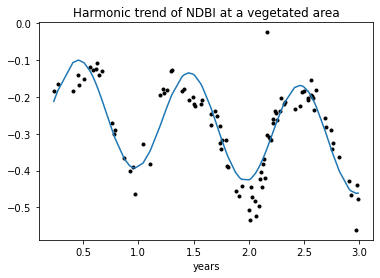

In [308]:
# roi_vegetation
data = harmonic_index_area(fittedHarmonic, 'NDBI',roi_vegetation)
time = harmonic_index_area(fittedHarmonic,'t',roi_vegetation)

plt.plot(list(time.values()),list(data.values()),  '.', color='black')
# plt.plot(list(data.values()))

data = harmonic_index_area(fittedHarmonic, 'fitted', roi_vegetation)
# plt.plot(list(data.values()),  '.', color='black')
plt.plot(list(time.values()),list(data.values()))

plt.title('Harmonic trend of NDBI at a vegetated area')
plt.xlabel('years')

plt.show()

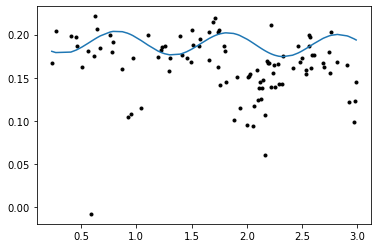

In [106]:
# roi_building
data = harmonic_index_area(fittedHarmonic, 'NDBI',roi_building)
time = harmonic_index_area(fittedHarmonic,'t',roi_building)

plt.plot(list(time.values()),list(data.values()),  '.', color='black')
data = harmonic_index_area(fittedHarmonic, 'fitted', roi_building)

plt.plot(list(time.values()),list(data.values()))

plt.title('Harmonic trend of NDBI at a building area')
plt.xlabel('years')

plt.show()

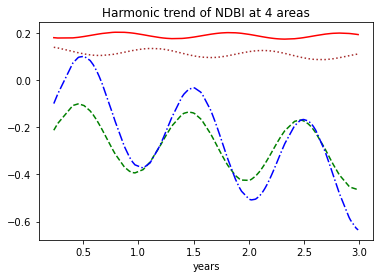

In [368]:
# compare harmonics at different areas
data_V = harmonic_index_area(fittedHarmonic, 'fitted', roi_vegetation)
data_BS = harmonic_index_area(fittedHarmonic, 'fitted', roi_baresoil)
data_W = harmonic_index_area(fittedHarmonic, 'fitted', roi_water)
data_B = harmonic_index_area(fittedHarmonic, 'fitted', roi_building)
time = harmonic_index_area(fittedHarmonic,'t',roi_vegetation)

plt.plot(list(time.values()),list(data_V.values()),'g--')
plt.plot(list(time.values()),list(data_BS.values()),':',color = 'brown')
plt.plot(list(time.values()),list(data_W.values()),'b-.')
plt.plot(list(time.values()),list(data_B.values()),color = 'red')

plt.title('Harmonic trend of NDBI at 4 areas')
plt.xlabel('years')

plt.show()

In [ ]:
# Plot the fitted model and the original data at the ROI.
#print(ui.Chart.image.series(
# fittedHarmonic.select(['fitted','NDBI']), roi, ee.Reducer.mean(), 30) \
#   .setSeriesNames(['NDBI', 'fitted']) \
#   .setOptions({
#     'title': 'Harmonic model: original and fitted values',
#     'lineWidth': 1,
#     'pointSize': 3,
# }))

In [ ]:
# Compute phase and amplitude.
phase_ndbi = harmonicTrendCoefficients.select('sin') \
  .atan2(harmonicTrendCoefficients.select('cos')) \
  .unitScale(-math.pi, math.pi) \
  .rename("HUE_NDBI")

amplitude_ndbi = harmonicTrendCoefficients.select('sin') \
  .hypot(harmonicTrendCoefficients.select('cos')) \
  .multiply(5) \
  .rename("SAT_NDBI")

# Compute the mean NDVI.
meanNdbi= collection.select('NDBI').mean().rename("VAL_NDBI")

# Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
        phase_ndbi,      # hue
        amplitude_ndbi,  # saturation (difference from white)
        meanNdbi    # value (difference from black)
        ]).hsvToRgb()

Add to map

In [ ]:
Map.addLayer(rgb, {}, 'phase_nmdi (hue), amplitude_nmdi (sat), nmdi (val')
Map

### BSI

Bare Soil Index (BSI) is a numerical indicator that combines blue, red, near infrared and short wave infrared spectral bands to capture soil variations.

In [376]:
# List of the independent variable names
independents = ee.List(['constant', 't'])

# Name of the dependent variable.
dependent = ee.String('BSI')

# Compute a linear trend.  This will have two bands: 'residuals' and
# a 2x1 band called coefficients (columns are for dependent variables).
trend = collection.select(independents.add(dependent)) \
  .reduce(ee.Reducer.linearRegression(independents.length(), 1))
# Map.addLayer(trend, {}, 'trend array image')

# Flatten the coefficients into a 2-band image
coefficients = trend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([independents])

In [377]:
# Compute a de-trended series.

def func_hzu(image):
    return image.select(dependent).subtract(
                image.select(independents).multiply(coefficients).reduce('sum')) \
                .rename(dependent) \
                .copyProperties(image, ['system:time_start'])

detrended = collection.map(func_hzu)

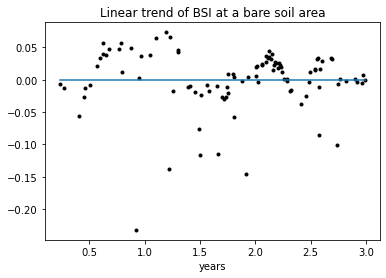

In [371]:
# roi_baresoil
data = index_area(detrended, 'BSI',roi_baresoil)
time = index_area(collection,'t', roi_baresoil)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')

x = range(len(data.items()))
a, b = np.polyfit(list(time.values()), list(data.values()), 1)
plt.plot(list(time.values()), a*x+b) 

plt.title('Linear trend of BSI at a bare soil area')
plt.xlabel('years')

plt.show()

In [ ]:
# Plot the detrended results.
# detrendedChart = ui.Chart.image.series(detrended, roi, None, 30) \
#   .setOptions({
#     'title': 'Detrended Sentinel time series at ROI',
#     'lineWidth': 1,
#     'pointSize': 3,
#   })
#print(detrendedChart)

In [378]:
# Use these independent variables in the harmonic regression.
harmonicIndependents = ee.List(['constant', 't', 'cos', 'sin'])

In [379]:
# Add harmonic terms as new image bands.

def func_knr(image):
    timeRadians = image.select('t').multiply(2 * math.pi)
    return image \
          .addBands(timeRadians.cos().rename('cos')) \
          .addBands(timeRadians.sin().rename('sin'))

harmonicLandsat = collection.map(func_knr)

harmonicTrend = harmonicLandsat \
.select(harmonicIndependents.add(dependent)) \
.reduce(ee.Reducer.linearRegression(
    **{
        'numX': harmonicIndependents.length(),
        'numY': 1
    }))
# Turn the array image into a multi-band image of coefficients.
harmonicTrendCoefficients = harmonicTrend.select('coefficients') \
.arrayProject([0]) \
.arrayFlatten([harmonicIndependents])

In [380]:
# Compute fitted values.

def func_fyi(image):
        return image.addBands(
          image.select(harmonicIndependents) \
            .multiply(harmonicTrendCoefficients) \
            .reduce('sum') \
            .rename('fitted'))

fittedHarmonic = harmonicLandsat.map(func_fyi)

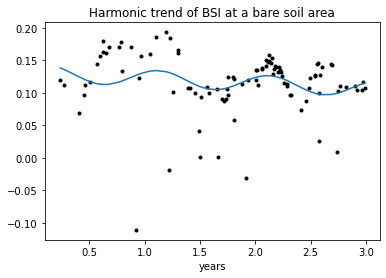

In [317]:
# roi_baresoil
data = harmonic_index_area(fittedHarmonic, 'BSI',roi_baresoil)
time = harmonic_index_area(fittedHarmonic,'t',roi_baresoil)
# print(time)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')
# plt.plot(list(data.values()),  '.', color='black')

data = harmonic_index_area(fittedHarmonic, 'fitted', roi_baresoil)
plt.plot(list(time.values()),list(data.values()))

plt.title('Harmonic trend of BSI at a bare soil area')
plt.xlabel('years')

plt.show()

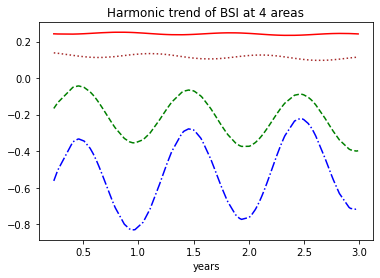

In [381]:
# compare harmonics at different areas
data_V = harmonic_index_area(fittedHarmonic, 'fitted', roi_vegetation)
data_BS = harmonic_index_area(fittedHarmonic, 'fitted', roi_baresoil)
data_W = harmonic_index_area(fittedHarmonic, 'fitted', roi_water)
data_B = harmonic_index_area(fittedHarmonic, 'fitted', roi_building)
time = harmonic_index_area(fittedHarmonic,'t',roi_vegetation)

plt.plot(list(time.values()),list(data_V.values()),'g--')
plt.plot(list(time.values()),list(data_BS.values()),':',color = 'brown')
plt.plot(list(time.values()),list(data_W.values()),'b-.')
plt.plot(list(time.values()),list(data_B.values()),color = 'red')

plt.title('Harmonic trend of BSI at 4 areas')
plt.xlabel('years')

plt.show()

In [ ]:
# Plot the fitted model and the original data at the ROI.
#print(ui.Chart.image.series(
# fittedHarmonic.select(['fitted','BSI']), roi, ee.Reducer.mean(), 30) \
#   .setSeriesNames(['BSI', 'fitted']) \
#   .setOptions({
#     'title': 'Harmonic model: original and fitted values',
#     'lineWidth': 1,
#     'pointSize': 3,
# }))
#

In [ ]:
# Compute phase and amplitude.
phase_bsi = harmonicTrendCoefficients.select('sin') \
  .atan2(harmonicTrendCoefficients.select('cos')) \
  .unitScale(-math.pi, math.pi) \
  .rename("HUE_BSI")

amplitude_bsi = harmonicTrendCoefficients.select('sin') \
  .hypot(harmonicTrendCoefficients.select('cos')) \
  .multiply(5) \
  .rename("SAT_BSI")

# Compute the mean BSI.
meanBsi= collection.select('BSI').mean().rename("VAL_BSI")

# Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
    phase_bsi,      # hue
    amplitude_bsi,  # saturation (difference from white)
    meanBsi    # value (difference from black)
    ]).hsvToRgb()

Add to the map

In [ ]:
Map.addLayer(rgb, {}, 'phase_bsi (hue), amplitude_bsi (sat), bsi (val)')
Map

### GRVI

Green and Red ratio Vegetation Index

In [382]:
# List of the independent variable names
independents = ee.List(['constant', 't'])

# Name of the dependent variable.
dependent = ee.String('GRVI')

# Compute a linear trend.  This will have two bands: 'residuals' and
# a 2x1 band called coefficients (columns are for dependent variables).
trend = collection.select(independents.add(dependent)) \
  .reduce(ee.Reducer.linearRegression(independents.length(), 1))
# Map.addLayer(trend, {}, 'trend array image')

# Flatten the coefficients into a 2-band image
coefficients = trend.select('coefficients') \
    .arrayProject([0]) \
    .arrayFlatten([independents])

In [383]:
# Compute a de-trended series.

def func_rwe(image):
    return image.select(dependent).subtract(
                image.select(independents).multiply(coefficients).reduce('sum')) \
                .rename(dependent) \
                .copyProperties(image, ['system:time_start'])

detrended = collection.map(func_rwe)

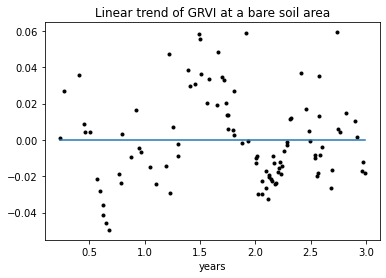

In [320]:
# roi_baresoil
data = index_area(detrended, 'GRVI',roi_baresoil)
time = index_area(collection,'t', roi_baresoil)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')

x = range(len(data.items()))
a, b = np.polyfit(list(time.values()), list(data.values()), 1)
plt.plot(list(time.values()), a*x+b) 

plt.title('Linear trend of GRVI at a bare soil area')
plt.xlabel('years')

plt.show()

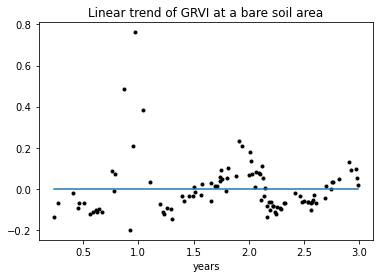

In [321]:
# roi_vegetation
data = index_area(detrended, 'GRVI',roi_vegetation)
time = index_area(collection,'t', roi_vegetation)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')

x = range(len(data.items()))
a, b = np.polyfit(list(time.values()), list(data.values()), 1)
plt.plot(list(time.values()), a*x+b) 

plt.title('Linear trend of GRVI at a bare soil area')
plt.xlabel('years')

plt.show()

In [384]:
# Plot the detrended results.
# detrendedChart = ui.Chart.image.series(detrended, roi, None, 30) \
#   .setOptions({
#     'title': 'Detrended Sentinel time series at ROI',
#     'lineWidth': 1,
#     'pointSize': 3,
#   })
#print(detrendedChart)

# Use these independent variables in the harmonic regression.
harmonicIndependents = ee.List(['constant', 't', 'cos', 'sin'])

In [385]:
# Add harmonic terms as new image bands.

def func_sze(image):
    timeRadians = image.select('t').multiply(2 * math.pi)
    return image \
          .addBands(timeRadians.cos().rename('cos')) \
          .addBands(timeRadians.sin().rename('sin'))

harmonicLandsat = collection.map(func_sze)

harmonicTrend = harmonicLandsat \
.select(harmonicIndependents.add(dependent)) \
.reduce(ee.Reducer.linearRegression(
    **{
        'numX': harmonicIndependents.length(),
        'numY': 1
    }))
# Turn the array image into a multi-band image of coefficients.
harmonicTrendCoefficients = harmonicTrend.select('coefficients') \
.arrayProject([0]) \
.arrayFlatten([harmonicIndependents])

In [386]:
# Compute fitted values.

def func_kuj(image):
    return image.addBands(
          image.select(harmonicIndependents) \
            .multiply(harmonicTrendCoefficients) \
            .reduce('sum') \
            .rename('fitted'))

fittedHarmonic = harmonicLandsat.map(func_kuj)

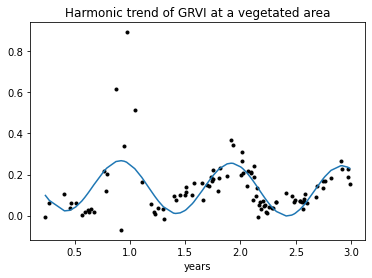

In [330]:
# roi_vegetation
data = harmonic_index_area(fittedHarmonic, 'GRVI',roi_vegetation)
time = harmonic_index_area(fittedHarmonic,'t',roi_vegetation)
# print(time)
plt.plot(list(time.values()),list(data.values()),  '.', color='black')
# plt.plot(list(data.values()),  '.', color='black')

data = harmonic_index_area(fittedHarmonic, 'fitted', roi_vegetation)
plt.plot(list(time.values()),list(data.values()))

plt.title('Harmonic trend of GRVI at a vegetated area')
plt.xlabel('years')

plt.show()

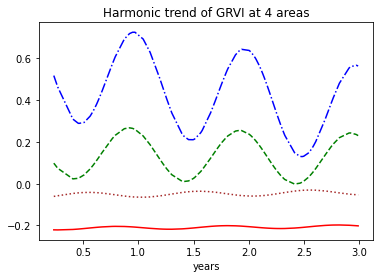

In [387]:
# compare harmonics at different areas
data_V = harmonic_index_area(fittedHarmonic, 'fitted', roi_vegetation)
data_BS = harmonic_index_area(fittedHarmonic, 'fitted', roi_baresoil)
data_W = harmonic_index_area(fittedHarmonic, 'fitted', roi_water)
data_B = harmonic_index_area(fittedHarmonic, 'fitted', roi_building)
time = harmonic_index_area(fittedHarmonic,'t',roi_vegetation)

plt.plot(list(time.values()),list(data_V.values()),'g--')
plt.plot(list(time.values()),list(data_BS.values()),':',color = 'brown')
plt.plot(list(time.values()),list(data_W.values()),'b-.')
plt.plot(list(time.values()),list(data_B.values()),color = 'red')

plt.title('Harmonic trend of GRVI at 4 areas')
plt.xlabel('years')

plt.show()

In [ ]:
# Plot the fitted model and the original data at the ROI.
#print(ui.Chart.image.series(
# fittedHarmonic.select(['fitted','GRVI']), roi, ee.Reducer.mean(), 30) \
#   .setSeriesNames(['GRVI', 'fitted']) \
#   .setOptions({
#     'title': 'Harmonic model: original and fitted values',
#     'lineWidth': 1,
#     'pointSize': 3,
# }))
#

In [ ]:
# Compute phase and amplitude.
phase_grvi = harmonicTrendCoefficients.select('sin') \
  .atan2(harmonicTrendCoefficients.select('cos')) \
  .unitScale(-math.pi, math.pi) \
  .rename("HUE_GRVI")

amplitude_grvi = harmonicTrendCoefficients.select('sin') \
  .hypot(harmonicTrendCoefficients.select('cos')) \
  .multiply(5) \
  .rename("SAT_GRVI")

# Compute the mean GRVI.
meanGrvi= collection.select('GRVI').mean().rename("VAL_GRVI")

# Use the HSV to RGB transform to display phase and amplitude.
rgb = ee.Image.cat([
    phase_grvi,      # hue
    amplitude_grvi,  # saturation (difference from white)
    meanGrvi    # value (difference from black)
    ]).hsvToRgb()

Add layer to map

In [ ]:
Map.addLayer(rgb, {}, 'phase_grvi (hue), amplitude_grvi (sat), grvi (val)')
Map

## Lag function

This function is not used.

In [ ]:
# use only in case of joining 2 collections of different times
def lag(leftCollection, rightCollection, lagDays):
    filter = ee.Filter.And(
        ee.Filter.maxDifference({
            'difference': 1000 * 60 * 60 * 24 * lagDays,
            'leftField': 'system:time_start',
            'rightField': 'system:time_start'
        }),
        ee.Filter.greaterThan({
            'leftField': 'system:time_start',
            'rightField': 'system:time_start'
        }))
    return ee.Join.saveAll({
        'matchesKey': 'images',
        'measureKey': 'delta_t',
        'ordering': 'system:time_start',
        'ascending': False, # Sort reverse chronologically
    }).apply({
        'primary': leftCollection,
        'secondary': rightCollection,
        'condition': filter
    })

## Select and extract bands

In [ ]:
print(OutBands)
final_bands= compclip.select(OutBands)
# print(final_bands.bandNames().getInfo())

In [ ]:
#Visualization of the final dataset using RGB and CIR
Map = geemap.Map()
Map.centerObject(Area_Nice)
Map.addLayer(final_bands, {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2'],}, 'RGB')
Map.addLayer(final_bands, {'min': 0.0, 'max': 0.3, 'bands': ['B8', 'B4', 'B3'],}, 'CIR')
Map

In [ ]:
#Add the index statistics to the median bands and clip the dataset with the ROI
compclip = band_median.addBands(ndvimax).addBands(ndvimean).addBands(ndvistd) \
    .addBands(nmdimax).addBands(nmdimean).addBands(nmdistd) \
    .addBands(ndbimax).addBands(ndbimean).addBands(ndbistd) \
    .addBands(phase_ndvi).addBands(amplitude_ndvi).addBands(meanNdvi) \
    .addBands(phase_nmdi).addBands(amplitude_nmdi).addBands(meanNmdi) \
    .addBands(phase_ndbi).addBands(amplitude_ndbi).addBands(meanNdbi) \
    .addBands(bsimax).addBands(bsimean).addBands(bsistd) \
    .addBands(evimax).addBands(evimean).addBands(evistd) \
    .addBands(grvimax).addBands(grvimean).addBands(grvistd) \
    .addBands(mndwimax).addBands(mndwimean).addBands(mndwistd) \
    .addBands(smmimax).addBands(smmimean).addBands(smmistd) \
    .addBands(phase_bsi).addBands(amplitude_bsi).addBands(meanBsi) \
    .addBands(phase_grvi).addBands(amplitude_grvi).addBands(meanGrvi) \
    .clip(Area_Nice)


print(compclip.bandNames().getInfo())

In [ ]:
OutBands  = ["B5","B7"#,"B6","B8A","B4","B11"
    ,"B8","B12"
    #,"NDVI_MAX","NDVI_STD"
    ,"NDBI_MAX","NDBI_STD"#,"HUE_NDVI","SAT_NDVI","NDVI"#,"VAL_NDVI",
    ,"NDBI","B2"#,"B3"#,"VAL_NDBI","HUE_NDBI","SAT_NDBI"
    #,"NMDI","NMDI_MAX","NMDI_STD","HUE_NMDI","SAT_NMDI","VAL_NMDI"
    #,"BSI","VAL_BSI"
    #,"BSI_STD","BSI_MAX","HUE_BSI","SAT_BSI"
    #,"EVI","EVI_MAX","EVI_STD"
    #,"GRVI","GRVI_STD","HUE_GRVI","GRVI_MAX","SAT_GRVI"//,"VAL_GRVI"
    #,"MNDWI","MNDWI_MAX","MNDWI_STD","SMMI","SMMI_MAX","SMMI_STD"
    ];

In [ ]:
outBands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12',
            
            # NDVI
            'NDVI_MAX', 'NDVI', 'NDVI_STD', 
            # NDVI T
            'HUE_NDVI', 'SAT_NDVI', 'VAL_NDVI',
            
            # NMDI
            'NMDI_MAX', 'NMDI', 'NMDI_STD', 
            # NMDI T
            'HUE_NMDI', 'SAT_NMDI', 'VAL_NMDI', 
            
            # NDBI
            'NDBI_MAX', 'NDBI', 'NDBI_STD', 
            # NDBI T
            'HUE_NDBI', 'SAT_NDBI', 'VAL_NDBI', 
            
            # GRVI
            'GRVI_MAX', 'GRVI', 'GRVI_STD', 
            # GRVI T
            'HUE_GRVI', 'SAT_GRVI', 'VAL_GRVI'

            # BSI
            'BSI_MAX', 'BSI', 'BSI_STD',
            # BSI T
            'HUE_BSI', 'SAT_BSI', 'VAL_BSI', 
            
            # EVI
            'EVI_MAX', 'EVI', 'EVI_STD', 
            # NMDWI
            'MNDWI_MAX', 'MNDWI', 'MNDWI_STD',
            # SMMI
            'SMMI_MAX', 'SMMI', 'SMMI_STD', 
           ]

Export regions

In [165]:
# split area in 4 zones
roi1 = ee.Geometry.Polygon(
        [[[6.642465422021031,43.53595758052378],[7.076425382958531,43.53595758052378],[7.076425382958531,43.87844627034738],[6.642465422021031,43.87844627034738],[6.642465422021031,43.53595758052378],]])
roi2  = ee.Geometry.Polygon(
        [[[6.719025509208998,43.87688879625747],[7.076081173271498,43.87688879625747],[7.076081173271498,44.36389752233614],[6.719025509208998,44.36389752233614],[6.719025509208998,43.87688879625747],]])
roi3  = ee.Geometry.Polygon(
        [[[7.073694731019966,43.53711239202778],[7.447229887269966,43.53711239202778],[7.447229887269966,43.879099567521784],[7.073694731019966,43.879099567521784],[7.073694731019966,43.53711239202778],]])
roi4 = ee.Geometry.Polygon(
        [[[7.070427585392207,43.87615487031022],[7.457695651798457,43.87615487031022],[7.457695651798457,44.193072642068195],[7.070427585392207,44.193072642068195],[7.070427585392207,43.87615487031022],]])

In [ ]:
# roi locations
Map = geemap.Map()
Map.addLayer(roi1,{'color': 'FF0000'},'roi1') # red
Map.addLayer(roi2,{'color': '00FF00'},'roi2') # green 
Map.addLayer(roi3,{'color': '0000FF'},'roi3') # blue
Map.addLayer(roi4,{'color': 'BF40BF'},'roi4') # purple
Map.centerObject(Area_Nice)

# Add legend
legend_dict = {
  'roi1':'FF0000',
  'roi2':'00FF00',
  'roi3':'0000FF',
  'roi4':'BF40BF',
}

Map.add_legend(legend_title="roi colors", legend_dict=legend_dict)
Map

Roi locations

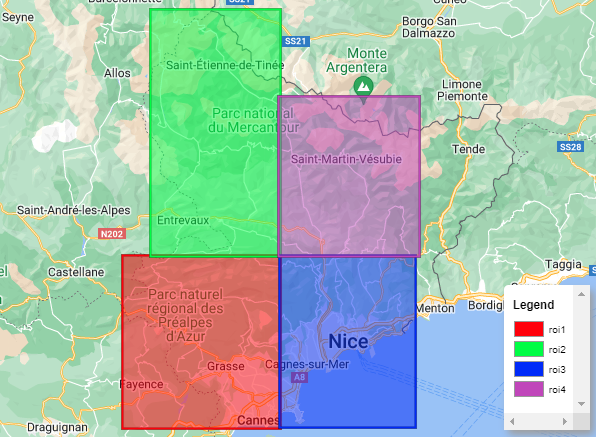

In [ ]:
#Export the images to an Earth Engine asset

# export compclip or final_bands?

task1 = ee.batch.Export.image.toAsset(
    image=compclip,
    region = roi1,
    scale=10,
    description='DATASET_COMPOSITION_Nice_allBands_T1',
    assetId='users/suzannacuypers/EARSeL/DATASET_COMPOSITION_Nice_T1') # 48 bands

task1.start()

task2 = ee.batch.Export.image.toAsset(
    image=compclip,
    region = roi2,
    scale=10,
    description='DATASET_COMPOSITION_Nice_allBands_T2',
    assetId='users/suzannacuypers/EARSeL/DATASET_COMPOSITION_Nice_T2')

task2.start()

task3 = ee.batch.Export.image.toAsset(
    image=compclip,
    region = roi3,
    scale=10,
    description='DATASET_COMPOSITION_Nice_allBands_T3',
    assetId='users/suzannacuypers/EARSeL/DATASET_COMPOSITION_Nice_T3')

task3.start()

task4 = ee.batch.Export.image.toAsset(
    image=compclip,
    region = roi4,
    scale=10,
    description='DATASET_COMPOSITION_Nice_allBands_T4',
    assetId='users/suzannacuypers/EARSeL/DATASET_COMPOSITION_Nice_T4')

task4.start()

In [ ]:
# too large
# export compclip or final_bands ?
filename = '/home/scuypers/GEE/outputs/05-23_DATASET_COMPOSITION_Nice_OO_9_T1.tif'
geemap.ee_export_image(
    compclip, filename=filename, scale=10, region=roi1, file_per_band=False
)

# Classification

## Preparing data

In [174]:
# loading data
num_classes = len([0,1,2,3,4,5,6,7,8,9]) # 10
#num_classes = len([1,2,3,4,5,6,7,8,9,10,11,12,13,14]) # 14
print('num_classes:', num_classes)

if num_classes == 10:
    # import assets
    training = ee.FeatureCollection('users/suzannacuypers/EARSeL/TrainingData_Nice_10')
    validation = ee.FeatureCollection('users/suzannacuypers/EARSeL/ValidationData_Nice_10')
    #training = ee.FeatureCollection('users/suzannacuypers/EARSeL/trainingData_Nice_new')
    #validation = ee.FeatureCollection('users/suzannacuypers/EARSeL/validationData_Nice_new')
    newfc = training # no remapping for _10
    valpnts = validation
    # remap labels
    #newfc = training.remap([1,2,3,4,5,6,7,10,11,12,13,14], [0,0,0,1,2,3,4,5,6,7,8,9], 'b1')
    #valpnts = validation.remap([1,2,3,4,5,6,7,10,11,12,13,14], [0,0,0,1,2,3,4,5,6,7,8,9], 'b1')

else:
    # import assets
    newfc = ee.FeatureCollection('users/suzannacuypers/EARSeL/trainingData_Nice_14')
    valpnts = ee.FeatureCollection('users/suzannacuypers/EARSeL/validationData_Nice_14')

num_classes: 10


Testing remap. This shows that the new samples contain micro labels.

In [108]:
# filter out points of class 0 and 15
randompoints_Nice = training
randompoints_0 = randompoints_Nice.filter(ee.Filter.eq("b1", 0)) # was 1, 2 , 3
randompoints_1 = randompoints_Nice.filter(ee.Filter.eq("b1", 1)) # was 4
randompoints_2 = randompoints_Nice.filter(ee.Filter.eq("b1", 2)) # was 5
randompoints_3 = randompoints_Nice.filter(ee.Filter.eq("b1", 3)) # was 6
randompoints_4 = randompoints_Nice.filter(ee.Filter.eq("b1", 4)) # was 7
randompoints_5 = randompoints_Nice.filter(ee.Filter.eq("b1", 5)) # was 10
randompoints_6 = randompoints_Nice.filter(ee.Filter.eq("b1", 6)) # was 11
randompoints_7 = randompoints_Nice.filter(ee.Filter.eq("b1", 7)) # was 12
randompoints_8 = randompoints_Nice.filter(ee.Filter.eq("b1", 8)) # was 13
randompoints_9 = randompoints_Nice.filter(ee.Filter.eq("b1", 9)) # was 14
randompoints_10 = randompoints_Nice.filter(ee.Filter.eq("b1", 10))
# display points on map
Map = geemap.Map()
Map.centerObject(randompoints_Nice)

# colors need to be updated
vis_0 = {'pointSize': 5,'color': 'FF5733'} #pointSize doesn't work

vis_1 = {'pointSize': 10,'color': 'B7E603'}
vis_2 = {'pointSize': 5,'color': 'B6FF45'}
vis_3 = {'pointSize': 10,'color': '5FB331'}
vis_4 = {'pointSize': 5,'color': '3FAF17'}
vis_5 = {'pointSize': 5,'color': '237605'}
vis_6 = {'pointSize': 5,'color': '43B680'}
vis_7 = {'pointSize': 5,'color': '9B621A'}
vis_8 = {'pointSize': 5,'color': '0691C3'}
vis_9 = {'pointSize': 5,'color': '085CB8'}

# create sepearte mask layers for each class in the labels image
labels = Nice.mosaic()
Nice_1 = labels.updateMask(labels.eq(1))
Nice_2 = labels.updateMask(labels.eq(2))
Nice_3 = labels.updateMask(labels.eq(3))
Nice_4 = labels.updateMask(labels.eq(4))
Nice_5 = labels.updateMask(labels.eq(5))
Nice_6 = labels.updateMask(labels.eq(6))
Nice_7 = labels.updateMask(labels.eq(7))
Nice_8 = labels.updateMask(labels.eq(8))
Nice_10 = labels.updateMask(labels.eq(10))
Nice_11 = labels.updateMask(labels.eq(11))
Nice_12 = labels.updateMask(labels.eq(12))
Nice_13 = labels.updateMask(labels.eq(13))
Nice_14 = labels.updateMask(labels.eq(14))

# add masks to map

Map.addLayer(Nice.mosaic(),{'min':0, 'max':14, 'palette':palette_labels},"Labels_Nice")
# Map.addLayer(Nice_1,{'palette':['FF5733']},"Label_1")
# Map.addLayer(Nice_2,{},"Label_2")
# Map.addLayer(Nice_3,{},"Label_3")
# Map.addLayer(Nice_4,{},"Label_4")
# Map.addLayer(Nice_5,{},"Label_5")
# Map.addLayer(Nice_6,{},"Label_6")
# Map.addLayer(Nice_7,{},"Label_7")
# Map.addLayer(Nice_8,{},"Label_8")

# Map.addLayer(Nice_10,{},"Label_10")
# Map.addLayer(Nice_11,{},"Label_11")
# Map.addLayer(Nice_12,{},"Label_12")
# Map.addLayer(Nice_13,{},"Label_13")
# Map.addLayer(Nice_14,{},"Label_14")

# add points to map

Map.addLayer(randompoints_0,vis_0,'randompoints_0')
Map.addLayer(randompoints_1,vis_1,'randompoints_1')
Map.addLayer(randompoints_2,vis_2,'randompoints_2')
Map.addLayer(randompoints_3,vis_3,'randompoints_3') # low presence
Map.addLayer(randompoints_4,vis_4,'randompoints_4') # low presence
Map.addLayer(randompoints_5,vis_5,'randompoints_5')
Map.addLayer(randompoints_6,vis_6,'randompoints_6') # low presence
Map.addLayer(randompoints_7,vis_7,'randompoints_7')
Map.addLayer(randompoints_8,vis_8,'randompoints_8')
Map.addLayer(randompoints_9,vis_9,'randompoints_9')
Map.addLayer(randompoints_10,vis_9,'randompoints_10')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Loading HR data

In [175]:
HR_data = ee.ImageCollection("users/andreanascetti/IEEE/Nice_Ortho").mosaic()
HR_data = HR_data.rename(['b1_R', 'b2_G', 'b3_B'])
# print(type(HR_data))

#nomalizing the HR data
RGB_MIN = 0
RGB_MAX = 255
normalized = HR_data.select(['b1_R', 'b2_G', 'b3_B']).unitScale(RGB_MIN, RGB_MAX)
# print(type(normalized))

Loading Composite images

In [176]:
image1 = ee.Image('users/suzannacuypers/EARSeL/DATASET_COMPOSITION_Nice_T1')
image2 = ee.Image('users/suzannacuypers/EARSeL/DATASET_COMPOSITION_Nice_T2')
image3 = ee.Image('users/suzannacuypers/EARSeL/DATASET_COMPOSITION_Nice_T3')
image4 = ee.Image('users/suzannacuypers/EARSeL/DATASET_COMPOSITION_Nice_T4')
# image1 = ee.Image('users/suzannacuypers/EARSeL/05-23_DATASET_COMPOSITION_Nice_OO_9_T1') # ['B5', 'B7', 'B8', 'B12', 'NDBI_MAX', 'NDBI_STD', 'NDBI', 'B2']
# image2 = ee.Image('users/suzannacuypers/EARSeL/05-23_DATASET_COMPOSITION_Nice_OO_9_T2')
# image3 = ee.Image('users/suzannacuypers/EARSeL/05-23_DATASET_COMPOSITION_Nice_OO_9_T3')
# image4 = ee.Image('users/suzannacuypers/EARSeL/05-23_DATASET_COMPOSITION_Nice_OO_9_T4')

# print(image1.bandNames().getInfo())

table1 = ee.FeatureCollection('users/andreanascetti/IEEE/Nice_Tiles') # all tile shapes of GT data
# table2 = Area_Nice # ??? # Table from users/andreanascetti/IEEE/Nice_Tiles

S2_data = ee.ImageCollection([image1,image2,image3,image4]).mosaic().clip(table1)
dataset = normalized.addBands(S2_data)
print(dataset.bandNames().getInfo())

['b1_R', 'b2_G', 'b3_B', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI_MAX', 'NDVI', 'NDVI_STD', 'NMDI_MAX', 'NMDI', 'NMDI_STD', 'NDBI_MAX', 'NDBI', 'NDBI_STD', 'HUE_NDVI', 'SAT_NDVI', 'VAL_NDVI', 'HUE_NMDI', 'SAT_NMDI', 'VAL_NMDI', 'HUE_NDBI', 'SAT_NDBI', 'VAL_NDBI', 'BSI_MAX', 'BSI', 'BSI_STD', 'EVI_MAX', 'EVI', 'EVI_STD', 'GRVI_MAX', 'GRVI', 'GRVI_STD', 'MNDWI_MAX', 'MNDWI', 'MNDWI_STD', 'SMMI_MAX', 'SMMI', 'SMMI_STD', 'HUE_BSI', 'SAT_BSI', 'VAL_BSI', 'HUE_GRVI', 'SAT_GRVI', 'VAL_GRVI']


In [29]:
# add layers to map
Map = geemap.Map()

Map.centerObject(table1)

Map.addLayer(image1,{},'image1') # one imported image
# Map.addLayer(table1,{},'area polygons')
Map.addLayer(dataset,{},'normalized RGB + S2 tiles')

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

Adding data to the map

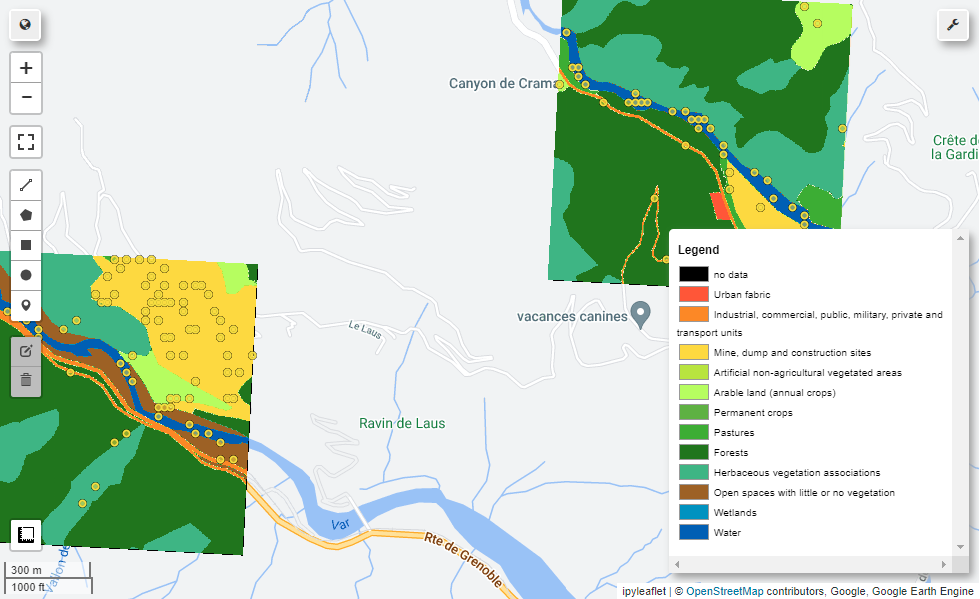

In [ ]:
Map = geemap.Map()#center=(43.708, 7.228), zoom=10)

groundTruth = ee.ImageCollection("users/andreanascetti/IEEE/Nice_Labels")

palette = [
  '000000',
  'FF5733', #(0)  Urban fabric
  'F98A04', #(1)  Industrial, commercial, public, military, private and transport units
  'FBDB10', #(2)  Mine, dump and construction sites
  'B7E603', #(3)  Artificial non-agricultural vegetated areas
  'B6FF45', #(4)  Arable land (annual crops)
  '5FB331', #(5)  Permanent crops
  '3FAF17', #(6)  Pastures
  'FCE5CD', #()complex and mixed...
  'C6ECB6', #()orchards at the fringe
  '237605', #(7)  Forests
  '43B680', #(8)  Herbaceous vegetation associations
  '9B621A', #(9)  Open spaces with little or no vegetation
  '0691C3', #(10)  Wetlands
  '085CB8', #(11)  Water
]

Map.centerObject(table1)

vis_params = {'color': 'f5e105ff'} # yellow

Map.addLayer(dataset, {'min': 0.0, 'max': 1.0, 'bands': ['b1_R', 'b2_G', 'b3_B'], }, 'RGB') # RGB + S2 data
Map.addLayer(groundTruth.mosaic(),{'min':0, 'max':14, 'palette':palette},"Labels_Nice")
# Map.addLayer(newfc,vis_params,'Training points')

Map.addLayer(training,{},'orig points')
Map.addLayer(newfc,vis_params,'remapped')

Map

Add legend if desired

In [ ]:
legend_dict = {
  'no data':'000000',
  'Urban fabric':'FF5733', #(0)  
  'Industrial, commercial, public, military, private and transport units':'F98A04', #(1)  
  'Mine, dump and construction sites':'FBDB10', #(2)  
  'Artificial non-agricultural vegetated areas':'B7E603', #(3)  
  'Arable land (annual crops)':'B6FF45', #(4)  
  'Permanent crops':'5FB331', #(5)  
  'Pastures':'3FAF17', #(6)  
  #'complex and mixed...':'FCE5CD', #()
  #'orchards at the fringe':'C6ECB6', #()
  'Forests':'237605', #(7)  
  'Herbaceous vegetation associations':'43B680', #(8)  
  'Open spaces with little or no vegetation':'9B621A', #(9)  
  'Wetlands':'0691C3', #(10)  
  'Water':'085CB8', #(11)  
  #'Clouds & Shadow':'000000',
}
Map.add_legend(legend_title="Land cover classes", legend_dict=legend_dict)

## Define the classifier

In [111]:
#if you want use RandomForest (classifier_alg= "RF") else use SVM (classifier_alg= "SVM")
classifier_alg = "RF"

In [ ]:
## original code 

'''
//If you decided to use the SVM algorithm it's mandatory the normalization of the input bands
if(classifier_alg =="SVM"){
  var image = ee.Image(dataset);
  // calculate the min and max value of an image
  var minMax = image.reduceRegion({
    reducer: ee.Reducer.minMax(),
    geometry: roi,
    scale: 20,
    maxPixels: 10e16,
  }); 
// use unit scale to normalize the pixel values
var dataset = ee.ImageCollection.fromImages(
  image.bandNames().map(function(name){
    name = ee.String(name);
    var band = image.select(name);
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))
})).toBands().rename(image.bandNames());
}
'''

In [112]:
#If you decided to use the SVM algorithm it's mandatory to normalize the input bands

def func_yvi(name):
    name = ee.String(name)
    band = image.select(name)
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))

if classifier_alg == "SVM":
    image = ee.Image(dataset)
    # calculate the min and max value of an image
    minMax = image.reduceRegion(
        **{
            'reducer': ee.Reducer.minMax(),
            'geometry': roi,
            'scale': 20,
            'maxPixels': 10e16,
        })
    # use unit scale to normalize the pixel values
    dataset = ee.ImageCollection.fromImages(
        image.bandNames().map(func_yvi)).toBands().rename(image.bandNames()) # go back to original band names

## Object Based Approach

### SNIC

In [189]:
# Segmentation using a SNIC approach based on the dataset previosly generated
size_segmentation = 10 # influences cluster size
seeds = ee.Algorithms.Image.Segmentation.seedGrid(size_segmentation)

# dataset.bandNames = ['b1_R', 'b2_G', 'b3_B', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'NDVI_MAX', 'NDVI', 'NDVI_STD', 'NMDI_MAX', 'NMDI', 'NMDI_STD', 'NDBI_MAX', 'NDBI', 'NDBI_STD', 'HUE_NDVI', 'SAT_NDVI', 'VAL_NDVI', 'HUE_NMDI', 'SAT_NMDI', 'VAL_NMDI', 'HUE_NDBI', 'SAT_NDBI', 'VAL_NDBI', 'BSI_MAX', 'BSI', 'BSI_STD', 'EVI_MAX', 'EVI', 'EVI_STD', 'GRVI_MAX', 'GRVI', 'GRVI_STD', 'MNDWI_MAX', 'MNDWI', 'MNDWI_STD', 'SMMI_MAX', 'SMMI', 'SMMI_STD', 'HUE_BSI', 'SAT_BSI', 'VAL_BSI', 'HUE_GRVI', 'SAT_GRVI', 'VAL_GRVI']
# paper: compactness = 0, connectivity = 8, and neighborhood size = 256
snic = ee.Algorithms.Image.Segmentation.SNIC(
    **{
        'image': dataset.select('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'),
        'compactness': 0, # influences the cluster shape (larger values produce more compact clusters)
        'connectivity': 8, # (4 or 8) defines if consider a Rook’s or Queen’s contiguity to merge adjacent clusters
        'neighborhoodSize': 256, # to avoid tile boundary artifacts
        'seeds': seeds
    })
print(snic.bandNames().getInfo())

clusters_snic = snic.select("clusters")
crs = clusters_snic.projection().getInfo()['crs'] # EPSG:2154 - RGF93 / Lambert-93 - Projected (given .tif files)
print(crs) # EPSG:4326

# SNIC outputs are variable depending on the visualization scale.
# Thus it is necessary to fix a proper output scale of clusters through the “reproject” function (S2 = 10)
snic_scale = 10 # 10
clusters_snic = clusters_snic.reproject (**{'crs': crs, 'scale': snic_scale})
snic = snic.reproject(**{'crs': crs, 'scale': snic_scale})

['clusters', 'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B8_mean', 'B8A_mean', 'B11_mean', 'B12_mean']
EPSG:4326


The result of snic are not just clusters, but also the mean values per band per cluster. The one-the-fly computation calculates the results at the zoom scale. This is and RGB image of b1_mean, b2_mean, and b3_mean:

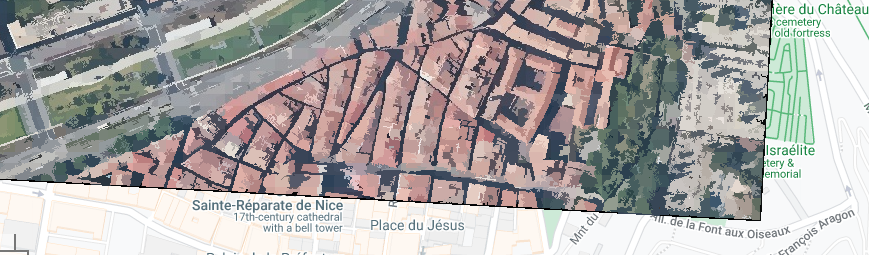

Map.addLayer(snic,{'bands':['b1_mean','b2_mean','b3_mean']},'snic RGB')

Scale 5, zoom level 15 (for first image)

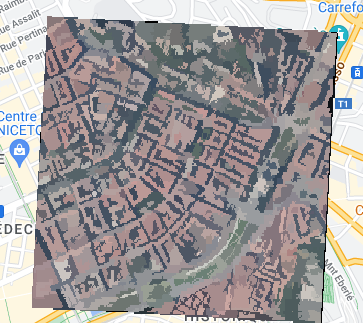

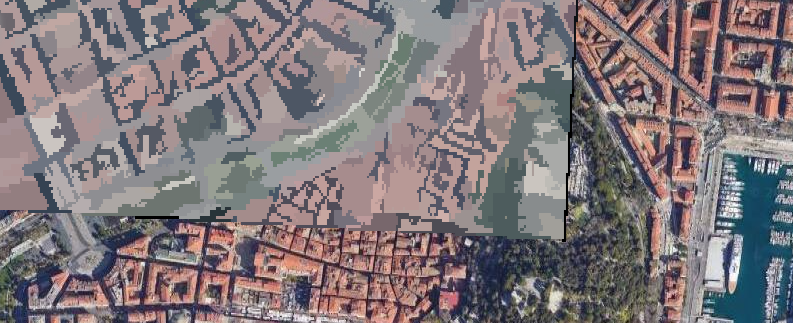

Visualization of snic band NDBI_MAX_mean: per snic cluster the mean of the NDBI_MAX values (of the image collection):

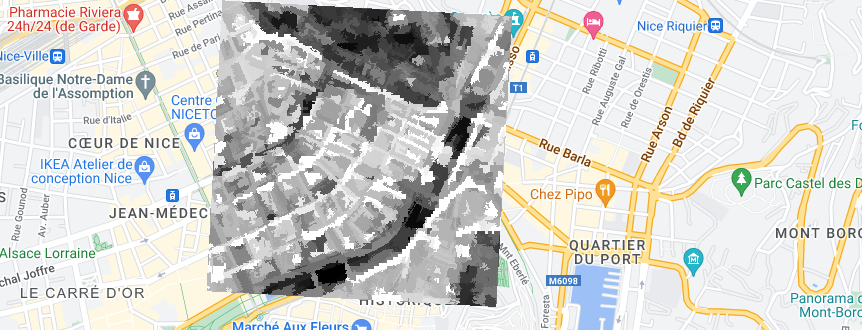

In [22]:
roi_tile = ee.Geometry.Polygon([[[7.266858, 43.696087], [7.266858, 43.707132], [7.282482, 43.707132], [7.282482, 43.696087], [7.266858, 43.696087]]])

In [191]:
Map = geemap.Map()

Map.centerObject(roi_tile,zoom = 17)

# Map.addLayer(snic,{'bands':['b1_R_mean','b2_G_mean','b3_B_mean']},'snic RGB')
Map.addLayer(snic,{'bands':['B4_mean','B3_mean','B2_mean']},'snic S2 RGB')
# Map.addLayer(clusters_snic.randomVisualizer(), {}, 'clusters')
Map

Map(center=[43.70160959647657, 7.274669999997794], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
roi = Map.user_roi 
print(roi.getInfo())

### GLCM

In [195]:
#Create and rescale a grayscale image for GLCM
# paper: Gray = (0.3 × NIR) + (0.59 × RED) + (0.11 × GREEN)

# gray = dataset.expression(
#       '(0.11 * B) + (0.3 * R) + (0.59 * G)', {
#       'B': dataset.select('b3_B'),
#       'R': dataset.select('b1_R'),
#       'G': dataset.select('b2_G')
# }).rename('gray')
# for S2 bands only
print('GLCM on S2 bands')
gray = dataset.expression(
      '(0.11 * GREEN) + (0.3 * NIR) + (0.59 * RED)', {
      'RED': dataset.select('B4'),
      'NIR': dataset.select('B8'),
      'GREEN': dataset.select('B3')
}).rename('gray')

# the glcmTexture size (in pixel) can be adjusted considering the spatial resolution and the object textural characteristics

glcm = gray.unitScale(0, 0.30).multiply(100).toInt().glcmTexture(**{'size': 2})
# print(type(glcm))
print(glcm.bandNames().getInfo()) 

# ['gray_asm', 'gray_contrast', 'gray_corr', 'gray_var', 'gray_idm',
#'gray_savg', 'gray_svar', 'gray_sent', 'gray_ent', 'gray_dvar', 
#'gray_dent', 'gray_imcorr1', 'gray_imcorr2', 'gray_maxcorr', 
#'gray_diss', 'gray_inertia', 'gray_shade', 'gray_prom']

['gray_asm', 'gray_contrast', 'gray_corr', 'gray_var', 'gray_idm', 'gray_savg', 'gray_svar', 'gray_sent', 'gray_ent', 'gray_dvar', 'gray_dent', 'gray_imcorr1', 'gray_imcorr2', 'gray_maxcorr', 'gray_diss', 'gray_inertia', 'gray_shade', 'gray_prom']


The selected GLCM metrics:

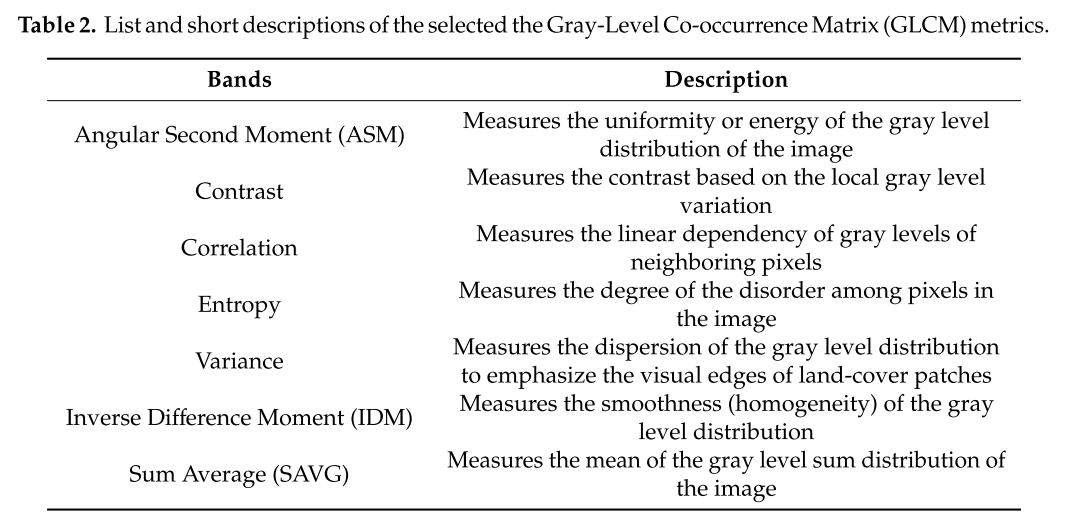

In [196]:
# Define the GLCM indices used in input for the PCA
glcm_bands= ["gray_asm","gray_contrast","gray_corr","gray_ent","gray_var","gray_idm","gray_savg"]

#--- Before the PCA the glcm bands are scaled
image = glcm.select(glcm_bands)
# print(type(image))

In [197]:
glcm = image
# if not performing PCA, skip the next step

In [198]:
# calculate the min and max value of an image
scale = 10 #10
minMax = image.reduceRegion(
    **{
        'reducer': ee.Reducer.minMax(),
        'geometry': Area_Nice,
        'scale': scale,
        'maxPixels': 10e16,
        'tileScale':8
    })

def func_ehv(name):
    name = ee.String(name)
    band = image.select(name)
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))

glcm = ee.ImageCollection.fromImages(image.bandNames().map(func_ehv)).toBands().rename(image.bandNames())
# glcm = image.bandNames().map(func_ehv).toBands().rename(image.bandNames())
print(glcm.bandNames().getInfo())

<class 'ee.image.Image'>
['gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg']


### PCA

For now, we skip PCA and add the GLCM bands not normalized to the snic bands.


Then, after a proper standardization, a PCA of the most relevant 7 GLCM metric (Table 2), selected
according to Hall-Beyer et al., is applied to derive a single representative band (the first PC) which generally contains the vast majority of the textural information.

In [159]:
# The code relating to the PCA was adapted from the GEE documentation  https:#developers.google.com/earth-engine/guides/arrays_eigen_analysis

# Get some information about the input to be used later.
scale = 5 #20 #glcm.projection().nominalScale()
print("Nominal Scale", scale)
bandNames = glcm.bandNames()
print(bandNames.getInfo()) # ['gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg']

# Mean center the data to enable a faster covariance reducer and an SD stretch of the principal components.
meanDict = glcm.reduceRegion(
    **{'reducer': ee.Reducer.mean(),
       'geometry': Area_Nice,
       'scale': scale,
       'maxPixels': 10e16,
       'tileScale':8
      })
means = ee.Image.constant(meanDict.values(bandNames)) # image with all pixels same value = mean of the band over the area
centered = glcm.subtract(means) # center distribution -> mean = 0 # for computation of PCA
print(type(centered))

Nominal Scale 20
['gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg']
<class 'ee.image.Image'>


PCA helper functions

In [160]:
# This helper function returns a list of new band names.
def getNewBandNames(prefix):
    seq = ee.List.sequence(1, bandNames.length())
    def func_rzr(b):
        return ee.String(prefix).cat(ee.Number(b).int())
    return seq.map(func_rzr)

In [120]:
# This function accepts mean centered imagery, a scale and a region in which to perform the analysis.
# It returns the Principal Components (PC) in the region as a new image.

def getPrincipalComponents(centered, scale, region):
    # Collapse the bands of the image into a 1D array per pixel.
    arrays = centered.toArray()
    # Compute the covariance of the bands within the region.
    covar = arrays.reduceRegion(
        **{'reducer': ee.Reducer.centeredCovariance(),
           'geometry': region,
           'scale': scale,
           'maxPixels': 10e16,
           'tileScale':8
          })

    # Get the 'array' covariance result and cast to an array.
    # This represents the band-to-band covariance within the region.
    covarArray = ee.Array(covar.get('array'))

    # Perform an eigen analysis and slice apart the values and vectors.
    eigens = covarArray.eigen()

    # This is a P-length vector of Eigenvalues.
    eigenValues = eigens.slice(1, 0, 1)
    # This is a PxP matrix with eigenvectors in rows.
    eigenVectors = eigens.slice(1, 1)

    # Convert the array image to 2D arrays for matrix computations.
    arrayImage = arrays.toArray(1)

    # Left multiply the image array by the matrix of eigenvectors.
    principalComponents = ee.Image(eigenVectors).matrixMultiply(arrayImage)

    # Turn the square roots of the Eigenvalues into a P-band image.
    sdImage = ee.Image(eigenValues.sqrt()) \
    .arrayProject([0]).arrayFlatten([getNewBandNames('sd')])

    # Turn the PCs into a P-band image, normalized by SD.
    return principalComponents \
        .arrayProject([0]) \
        .arrayFlatten([getNewBandNames('pc')]) \
        .divide(sdImage)

In [121]:
print(type(centered))
pcImage = getPrincipalComponents(centered, scale, Area_Nice)
print(type(pcImage))

<class 'ee.image.Image'>
<class 'ee.image.Image'>


### Combining the analyses

The average of PC1 is then calculated in a separate band for each object included in the SNIC “clusters” band. The PC1 object-averaged band is finally added to those extracted from the SNIC segmentation process.

In [199]:
#Select the band "clusters" from the snic output fixed on its scale of 10 meters and add them to the PC1 taken from the PCA data.
# Calculate the mean for each segment with respect to the pixels in that cluster
print(clusters_snic.bandNames().getInfo())
print(snic.bandNames().getInfo())
# print(pcImage.bandNames().getInfo())

['clusters']
['clusters', 'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B8_mean', 'B8A_mean', 'B11_mean', 'B12_mean']


In [200]:
### add GLCM bands without performing PCA
snic_glcm = snic.addBands(glcm)#(pcImage.select("pc1"))

# all GLCM bands should be reduced per cluster
snic_glcm_mean = snic_glcm.reduceConnectedComponents(
    **{
      'reducer': ee.Reducer.mean(),
      'labelBand': 'clusters'
    }) # mean of band per cluster

#Create a dataset with the new band used so far together with the band "clusters" and their new mean parameters
final_bands = snic_glcm_mean#.addBands(snic) # snic band contains clusters and all mean values of other bands per cluster
# print(snic.bandNames().getInfo())
# print(type(final_bands))
print(final_bands.bandNames().getInfo())

['B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B8_mean', 'B8A_mean', 'B11_mean', 'B12_mean', 'gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg']


In [204]:
Map = geemap.Map()
Map.centerObject(roi_tile,zoom=15)
Map.addLayer(final_bands,{'bands': ['gray_contrast'], 'min': 0.0, 'max': .05},'final bands')
Map

Map(center=[43.70160959647657, 7.274669999997794], controls=(WidgetControl(options=['position', 'transparent_b…

In [212]:
# export SNIC after combining with GLCM
to_export = final_bands # snic
name_asset = 'users/suzannacuypers/EARSeL/snic_GLCMs2_ss10_T1'
task = ee.batch.Export.image.toAsset(
    image = to_export,
    region = roi1,
    scale=scale, # meter
    description='snic GLCMs2_ss10 T1',
    assetId=name_asset)

task.start()

In [213]:
name_asset = 'users/suzannacuypers/EARSeL/snic_GLCMs2_ss10_T2'
task = ee.batch.Export.image.toAsset(
    image = to_export,
    region = roi2,
    scale=scale, # meter
    description='snic GLCMs2_ss10 T2',
    assetId=name_asset)

task.start()

name_asset = 'users/suzannacuypers/EARSeL/snic_GLCMs2_ss10_T3'
task = ee.batch.Export.image.toAsset(
    image = to_export,
    region = roi3,
    scale=scale, # meter
    description='snic GLCMs2_ss10 T3',
    assetId=name_asset)

task.start()

name_asset = 'users/suzannacuypers/EARSeL/snic_GLCMs2_ss10_T4'
task = ee.batch.Export.image.toAsset(
    image = to_export,
    region = roi4,
    scale=scale, # meter
    description='snic GLCMs2_ss10 T4',
    assetId=name_asset)

task.start()

### Import SNIC + GLCM + compclip

Import the final bands on which to perform classification = snic of (RGB + S2) + GLCM (per snic cluster).

In [229]:
# import "final bands"
ss = 10
S2_snic = True
if ss == 5 and S2_snic == False: # does not work
    final_bands_T1 = ee.Image('users/suzannacuypers/EARSeL/snic_GLCM_ss5_T1')
    final_bands_T2 = ee.Image('users/suzannacuypers/EARSeL/snic_GLCM_ss5_T2')
    final_bands_T3 = ee.Image('users/suzannacuypers/EARSeL/snic_GLCM_ss5_T3')
    final_bands_T4 = ee.Image('users/suzannacuypers/EARSeL/snic_GLCM_ss5_T4')
elif ss == 10 and S2_snic == False:
    final_bands_T1 = ee.Image('users/suzannacuypers/EARSeL/snic_GLCM_ss10_T1')
    final_bands_T2 = ee.Image('users/suzannacuypers/EARSeL/snic_GLCM_ss10_T2')
    final_bands_T3 = ee.Image('users/suzannacuypers/EARSeL/snic_GLCM_ss10_T3')
    final_bands_T4 = ee.Image('users/suzannacuypers/EARSeL/snic_GLCM_ss10_T4')
elif ss == 10 and S2_snic == True:
    # for SNIC based on all 12 S2 bands:
    final_bands_T1 = ee.Image('users/suzannacuypers/EARSeL/snic_GLCMs2_ss10_T1')
    final_bands_T2 = ee.Image('users/suzannacuypers/EARSeL/snic_GLCMs2_ss10_T2')
    final_bands_T3 = ee.Image('users/suzannacuypers/EARSeL/snic_GLCMs2_ss10_T3')
    final_bands_T4 = ee.Image('users/suzannacuypers/EARSeL/snic_GLCMs2_ss10_T4')

print(final_bands_T1.bandNames().getInfo())

['B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B8_mean', 'B8A_mean', 'B11_mean', 'B12_mean', 'gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg']


In [230]:
table1 = ee.FeatureCollection('users/andreanascetti/IEEE/Nice_Tiles') # all tile shapes of GT data

final_bands = ee.ImageCollection([final_bands_T1,final_bands_T2,final_bands_T3,final_bands_T4]).mosaic().clip(table1)

In [216]:
# snic doesn't rescale with zoom
Map = geemap.Map()
Map.centerObject(final_bands_T2)
Map.addLayer(final_bands_T2,{},'final bands T2')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [231]:
print(final_bands.bandNames().getInfo())

['B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B8_mean', 'B8A_mean', 'B11_mean', 'B12_mean', 'gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg']


### Selecting the predictionBands.

In [232]:
#Define the training bands removing just the "clusters" bands
# predictionBands  = final_bands.bandNames().remove("clusters") # a list
# print(predictionBands.getInfo())

predictionBands = ['b1_mean', 'b2_mean', 'b3_mean',
                   'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B8_mean', 'B8A_mean', 'B11_mean', 'B12_mean',
                   'NDVI_MAX_mean', 'NDVI_mean', 'NDVI_STD_mean', 
                   'NMDI_MAX_mean', 'NMDI_mean', 'NMDI_STD_mean', 
                   'NDBI_MAX_mean', 'NDBI_mean', 'NDBI_STD_mean', 
                   'BSI_MAX_mean', 'BSI_mean', 'BSI_STD_mean',
                   'EVI_MAX_mean', 'EVI_mean', 'EVI_STD_mean',
                   'GRVI_MAX_mean', 'GRVI_mean', 'GRVI_STD_mean',
                   'MNDWI_MAX_mean', 'MNDWI_mean', 'MNDWI_STD_mean',
                   'SMMI_MAX_mean', 'SMMI_mean', 'SMMI_STD_mean',
                   'HUE_NDVI_mean', 'SAT_NDVI_mean', 'VAL_NDVI_mean',
                   'HUE_NMDI_mean', 'SAT_NMDI_mean', 'VAL_NMDI_mean',
                   'HUE_NDBI_mean', 'SAT_NDBI_mean', 'VAL_NDBI_mean', 
                   'HUE_BSI_mean', 'SAT_BSI_mean', 'VAL_BSI_mean', 
                   'HUE_GRVI_mean', 'SAT_GRVI_mean', 'VAL_GRVI_mean',
                   'gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg'
                  ]

predictionBands = [
    'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B8_mean', 'B8A_mean', 'B11_mean', 'B12_mean',

]
# predictionBands = predictionBands[15:] # first 30 best

In [233]:
print(len(predictionBands))

10


In [ ]:
'''
//---- Normalize all data if you decide to use the SVM classifier
if (classifier_alg=="SVM"){
  
var minMax = final_bands.reduceRegion(**{
  reducer: ee.Reducer.minMax(),
  geometry: roi,
  scale: scale,
  maxPixels: 10e16,
  tileScale:8
});
'''

'''final_bands = ee.ImageCollection.fromImages(
    final_bands.bandNames().map(function(name){
        name = ee.String(name)
        band = final_bands.select(name)
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))
})).toBands().rename(final_bands.bandNames())'''

'''
def func_mgp(name):
    name = ee.String(name)
    band = final_bands.select(name)
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))


final_bands = ee.ImageCollection.fromImages(final_bands.bandNames().map(func_mgp)).toBands().rename(final_bands.bandNames())
'''

### Training the classifier

In [8]:
#if you want use RandomForest (classifier_alg= "RF") else use SVM (classifier_alg= "SVM")
classifier_alg = "RF"

As generally performed, a band normalization of the input dataset was applied before applying the SVM classification. For the RF classifier, the number of trees was set to 50, while for the SVM a radial basis function kernel (RBF) was applied (with gamma = 1 and cost = 10).

In [234]:
# Classification using the classifier with the training bands called predictionBands
print(predictionBands)#.getInfo()) # list
print(final_bands.bandNames().getInfo()) # dataset

['B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B8_mean', 'B8A_mean', 'B11_mean', 'B12_mean']
['B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B8_mean', 'B8A_mean', 'B11_mean', 'B12_mean', 'gray_asm', 'gray_contrast', 'gray_corr', 'gray_ent', 'gray_var', 'gray_idm', 'gray_savg']


In [235]:
# training dataset

#To improve the amount of supervised information, a buffer with a fixed radius (10 m) is created around each point.
def buffer(feature):
    return feature.buffer(40)

buffered_newfc = newfc.map(buffer)

scale = 10
training_geobia = final_bands.select(predictionBands).sampleRegions(
    **{
      'collection': buffered_newfc,
      'properties': ['b1'],
      'scale': scale, # A nominal scale in meters of the projection to sample in. If unspecified,the scale of the image's first band is used.
      'tileScale':8
})

In [237]:
print(training_geobia.first().getInfo())

{'type': 'Feature', 'geometry': None, 'id': '00000000000000000000_0', 'properties': {'B11_mean': 0.17846331000328064, 'B12_mean': 0.11419057846069336, 'B2_mean': 0.036957088857889175, 'B3_mean': 0.05750960111618042, 'B4_mean': 0.05666964128613472, 'B5_mean': 0.09749820083379745, 'B6_mean': 0.1910633146762848, 'B7_mean': 0.22255122661590576, 'B8A_mean': 0.24460545182228088, 'B8_mean': 0.23694545030593872, 'b1': 0}}


In [238]:
#Training the classifier
if classifier_alg == "RF":
    classifier = ee.Classifier.smileRandomForest(25).train(**{
        'features':training_geobia,
        'classProperty':'b1',
        'inputProperties': predictionBands
    })

elif classifier_alg == "SVM":
    classifier = ee.Classifier.libsvm(**{
        'kernelType': 'RBF',
        'gamma': 15,
        'cost': 10
    })
    classifier = classifier.train(training_geobia, 'b1', predictionBands)

else:
    print("You need to set your classifier for the Object based approach")
    
classifier_OO = classifier
print("Training finished")

Training finished


### Classifying

In [239]:
# classify the tiles
classy_RF = final_bands.select(predictionBands).classify(classifier_OO)

In [ ]:
# print(type(classy_RF))
# print(classy_RF.bandNames().getInfo())

Add classification layer to the map

In [ ]:
# crs = classy_RF.projection().getInfo()['crs']
# crs = classy_RF.projection()

# classy_RF = classy_RF.reproject (**{'crs': crs, 'scale': scale})


In [18]:
roi_tile_2 = ee.Geometry.Polygon(
    [[7.192661, 43.707893], [7.192661, 43.718837], [7.210173, 43.718837], [7.210173, 43.707893], [7.192661, 43.707893]]
)

In [240]:
Map = geemap.Map()
Map.center_object(roi_tile_2)
# classy_RF = classy_RF.reproject ({'crs': classy_RF.projection(), 'scale': scale})
palette = [
  'FF5733', #(0)  Urban fabric
#   'F98A04', #(1)  Industrial, commercial, public, military, private and transport units
#   'FBDB10', #(2)  Mine, dump and construction sites
  'B7E603', #(1)  Artificial non-agricultural vegetated areas
  'B6FF45', #(2)  Arable land (annual crops)
  '5FB331', #(3)  Permanent crops
  '3FAF17', #(4)  Pastures
#   'FCE5CD', #()complex and mixed...
#   'C6ECB6', #()orchards at the fringe
  '237605', #(5)  Forests
  '43B680', #(6)  Herbaceous vegetation associations
  '9B621A', #(7)  Open spaces with little or no vegetation
  '0691C3', #(8)  Wetlands
  '085CB8', #(9)  Water
]
palette_14 = [
  'FF5733', #(1)  Urban fabric
   'F98A04', #(2)  Industrial, commercial, public, military, private and transport units
   'FBDB10', #(3)  Mine, dump and construction sites
  'B7E603', #(4)  Artificial non-agricultural vegetated areas
  'B6FF45', #(5)  Arable land (annual crops)
  '5FB331', #(6)  Permanent crops
  '3FAF17', #(7)  Pastures
  '237605', #(10)  Forests
  '43B680', #(11)  Herbaceous vegetation associations
  '9B621A', #(12)  Open spaces with little or no vegetation
  '0691C3', #(13)  Wetlands
  '085CB8', #(14)  Water
]# print(classy_RF.bandNames().getInfo())

if num_classes == 10:
    Map.addLayer(classy_RF,{'min':0, 'max':9, 'palette':palette},'classification')
else:
    Map.addLayer(classy_RF,{'min':1, 'max':14, 'palette':palette_14},'classification')

legend_dict = {
#   'no data':'000000',
  'Urban, Indusctrial, Mine':'FF5733', #(0)  
   'Industrial, commercial, public, military, private and transport units':'F98A04', #(1)  
   'Mine, dump and construction sites':'FBDB10', #(2)  
  'Artificial non-agricultural vegetated areas':'B7E603', #(3)  
  'Arable land (annual crops)':'B6FF45', #(4)  
  'Permanent crops':'5FB331', #(5)  
  'Pastures':'3FAF17', #(6)  
  #'complex and mixed...':'FCE5CD', #()
  #'orchards at the fringe':'C6ECB6', #()
  'Forests':'237605', #(7)  
  'Herbaceous vegetation associations':'43B680', #(8)  
  'Open spaces with little or no vegetation':'9B621A', #(9)  
  'Wetlands':'0691C3', #(10)  
  'Water':'085CB8', #(11)  
}

#Map.add_legend(legend_title="Land cover classes", legend_dict=legend_dict)

Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### Exporting the classification

In [ ]:
# export classified image to asset per roi
# print(predictionBands.getInfo())

In [ ]:
# task1 = ee.batch.Export.image.toAsset(
#     image=classy_RF,
#     region = roi1,
#     scale=10,
#     description='classy RF OO',
#     assetId='users/suzannacuypers/EARSeL/Classy_RF_OO_T1')

# task1.start()

In [ ]:
# task1 = ee.batch.Export.image.toAsset(
#     image=classy_RF,
#     region = roi2,
#     scale=10,
#     description='classy RF OO',
#     assetId='users/suzannacuypers/EARSeL/Classy_RF_OO_T2')

# task1.start()

# task1 = ee.batch.Export.image.toAsset(
#     image=classy_RF,
#     region = roi3,
#     scale=10,
#     description='classy RF OO',
#     assetId='users/suzannacuypers/EARSeL/Classy_RF_OO_NDBI_T3')

# task1.start()

# task1 = ee.batch.Export.image.toAsset(
#     image=classy_RF,
#     region = roi4,
#     scale=10,
#     description='classy RF OO',
#     assetId='users/suzannacuypers/EARSeL/Classy_RF_OO_NDBI_T4')

# task1.start()

In [20]:
palette_10 = [
  'FF5733', #(0)  Urban fabric,  Industrial, commercial, public, military, private and transport units, Mine, dump and construction sites
  'B7E603', #(1)  Artificial non-agricultural vegetated areas
  'B6FF45', #(2)  Arable land (annual crops)
  '5FB331', #(3)  Permanent crops
  '3FAF17', #(4)  Pastures
    
  '237605', #(5)  Forests
  '43B680', #(6)  Herbaceous vegetation associations
  '9B621A', #(7)  Open spaces with little or no vegetation
  '0691C3', #(8)  Wetlands
  '085CB8', #(9)  Water
    '000000' # 15
]

In [21]:
Map = geemap.Map()
Map.centerObject(roi_tile)

Map.addLayer(Nice.mosaic(), {'min':0, 'max':14, 'palette':palette_labels}, 'Labels') # convert dataset to tile layer

Map.addLayer(imported_classy,{'min':0, 'max':10, 'palette':palette_10}, 'import')

Map

NameError: name 'roi_tile' is not defined

In [ ]:
# from PIL import Image
# import imageio
# import os
# import matplotlib.pyplot as plt
# import numpy as np

# im = imageio.imread('./outputs/tile_classy_10_1.tif')

# print(im.shape)
# print(np.unique(im))
# print(im)

In [ ]:
GT_image = Nice.mosaic()
# # remap the GT labels
if num_classes == 10:
    GT_image = GT_image.remap([1,2,3,4,5,6,7,10,11,12,13,14], [0,0,0,1,2,3,4,5,6,7,8,9],15).rename('b1')

# Export each tile as tiff
export_scale = 10 # 3 is smallest export scale
crs = ee.Projection('EPSG:2154') #- RGF93 / Lambert-93 - Projected
GT_image = GT_image.reproject(**{'crs': crs, 'scale': scale})
classy_RF = classy_RF.reproject(**{'crs': crs, 'scale': scale})

index = 0
for tile_dict in table1.getInfo()['features']:
    index += 1
    print(index)
    tile_geom = tile_dict['geometry']
    item_from_table = table1.filterBounds(tile_geom)
    print(item_from_table.getInfo()['features'])
    name = item_from_table.getInfo()['features'][-1]['properties']['name']
    print(name)
    tile_geom = ee.Geometry.Polygon(tile_geom['coordinates'],None,False)
    # to export all bands as a single iamge
    #GT_image = GT_image.clip(tile_geom).unmask() 
    #geemap.ee_export_image(
    #    GT_image, filename='./outputs/tile_GT_{}_{}.tif'.format(export_scale,index), scale=export_scale, region=tile_geom, file_per_band=False
    #)
    geemap.ee_export_image(
        GT_image, filename='/geomatics/gpuserver-0/scuypers/GEE_outputs/GT_{}.tif'.format(name), scale=export_scale, region=tile_geom, file_per_band=False
    )
    tile_classy = classy_RF.clip(tile_geom)
    #print(type(tile_classy))
    #Map.addLayer(tile_classy,{'min':0, 'max':9, 'palette':palette},'classy_{}'.format(index))
    geemap.ee_export_image(
        tile_classy, \
        filename='/geomatics/gpuserver-0/scuypers/GEE_outputs/{}_classy.tif'.format(name), \
        region = tile_geom, \
        scale=export_scale,\
        file_per_band=False
    )


### Importing classified images

In [ ]:
# ## importing tiff tiles
# import rasterio
# import os
# import matplotlib.pyplot as plt
# import numpy as np
# import PIL
# from PIL import Image

# In [4]: img = Image.open('image.tif')


# big_CM = np.zeros((16, 16),dtype=int)
# aantal = 3 # number of images to show
# index = 0
# for filename in os.listdir(directory):
#     if filename.endswith(".tif") and filename.startswith('classy') and index < aantal:
#         index += 1
#         print(filename)
#         img = Image.open(directory+filename)
#         image = np.array(img)
#         print(image.shape)

In [ ]:
#         # mask
#         data = np.array(dset)
#         print(data.shape)
#         unique = np.unique(dset)
#         print(unique)
#         plt.figure(figsize=(5,5))
#         plt.imshow(data)
#         plt.title('prediction')
#         plt.show()
                
#         # GT of mask_best
#         filename_GT = filename.replace('classy_RF','GT_image')
#         dsetGT = rasterio.open(directory+filename_GT)
#         print(filename_GT)
        
#         # original size GT
#         dataGT = np.array(dsetGT[:,:])
#         uniqueGT = np.unique(dataGT)
#         #print(uniqueGT)
#         plt.figure(figsize=(5,5))
#         plt.imshow(dataGT)
#         plt.title('GT')
#         plt.show()

        
#         m = tf.keras.metrics.MeanIoU(num_classes=15+1)
#         m.update_state(dataGT.flatten(), data.flatten()) # truth, prediciton
#         #print(m.result().numpy()) # mean IoU
#         # confusion matrix
#         tile_CM = np.array(m.get_weights(),dtype=int).reshape(15+1,15+1)
#         # add tile CM to big CM
#         sum_CM = np.add(big_CM,tile_CM)
#         big_CM = sum_CM.copy()

In [ ]:
# # import "final bands"
# classy_T1 = ee.Image('users/suzannacuypers/EARSeL/Classy_RF_OO_NDBI_T1')
# classy_T2 = ee.Image('users/suzannacuypers/EARSeL/Classy_RF_OO_NDBI_T2')
# classy_T3 = ee.Image('users/suzannacuypers/EARSeL/Classy_RF_OO_NDBI_T3')
# classy_T4 = ee.Image('users/suzannacuypers/EARSeL/Classy_RF_OO_NDBI_T4')

# # print(classy_T1.bandNames().getInfo()) # ['classification']

# table1 = ee.FeatureCollection('users/andreanascetti/IEEE/Nice_Tiles') # all tile shapes of GT data

# classy_RF = ee.ImageCollection([classy_T1,classy_T2,classy_T3,classy_T4]).mosaic().clip(table1)

In [ ]:
# split map
Map = geemap.Map()
Map.center_object(roi_tile)

# labels
Nice = ee.ImageCollection("users/andreanascetti/IEEE/Nice_Labels")

palette_labels = [
  '000000',
  'FF5733', #(0)  Urban fabric
  'F98A04', #(1)  Industrial, commercial, public, military, private and transport units
  'FBDB10', #(2)  Mine, dump and construction sites
  'B7E603', #(3)  Artificial non-agricultural vegetated areas
  'B6FF45', #(4)  Arable land (annual crops)
  '5FB331', #(5)  Permanent crops
  '3FAF17', #(6)  Pastures
  'FCE5CD', #()complex and mixed...
  'C6ECB6', #()orchards at the fringe
  '237605', #(7)  Forests
  '43B680', #(8)  Herbaceous vegetation associations
  '9B621A', #(9)  Open spaces with little or no vegetation
  '0691C3', #(10)  Wetlands
  '085CB8', #(11)  Water
]

left_layer = geemap.ee_tile_layer(Nice.mosaic(), {'min':0, 'max':14, 'palette':palette_labels}, 'Labels') # convert dataset to tile layer

# classification
if num_classes == 10:
    right_layer = geemap.ee_tile_layer(classy_RF, {'min':0, 'max':9, 'palette':palette}, 'classification')
else:
    right_layer = geemap.ee_tile_layer(classy_RF, {'min':1, 'max':14, 'palette':palette_14}, 'classification')

# legend
Map.add_legend(legend_title="Land cover classes", legend_dict=legend_dict)

Map.split_map(left_layer, right_layer)
Map

In [ ]:
# single map
Map = geemap.Map()
Map.center_object(roi_tile)

# labels
Nice = ee.ImageCollection("users/andreanascetti/IEEE/Nice_Labels")

Map.addLayer(Nice.mosaic(),{'min':0, 'max':14, 'palette':palette_labels},"Labels Nice")

palette_10 = [
  'FF5733', #(0)  Urban fabric,  Industrial, commercial, public, military, private and transport units, Mine, dump and construction sites
  'B7E603', #(1)  Artificial non-agricultural vegetated areas
  'B6FF45', #(2)  Arable land (annual crops)
  '5FB331', #(3)  Permanent crops
  '3FAF17', #(4)  Pastures
    
  '237605', #(5)  Forests
  '43B680', #(6)  Herbaceous vegetation associations
  '9B621A', #(7)  Open spaces with little or no vegetation
  '0691C3', #(8)  Wetlands
  '085CB8', #(9)  Water
    '000000' # 15
]
from_list = [0, 1,2,3,4,5,6,7,8, 9, 10,11,12,13,14]
to_list =   [15,0,0,0,1,2,3,4,15,15 ,5, 6, 7, 8, 9]
# GT_image = GT_image.remap([1,2,3,4,5,6,7,10,11,12,13,14], [0,0,0,1,2,3,4,5,6,7,8,9],15).rename('b1')
GT_image = GT_image.remap(from_list, to_list,16).rename('b1')
Map.addLayer(GT_image,{'min':0, 'max':15, 'palette':palette_10},"Labels Nice remapped")



# # classification
# if num_classes == 10:
#     Map.addLayer(classy_RF,{'min':0, 'max':9, 'palette':palette},'classification')
# else:
#     Map.addLayer(classy_RF,{'min':1, 'max':14, 'palette':palette_14},'classification')

# legend
Map.add_legend(legend_title="Land cover classes", legend_dict=legend_dict)

Map

In [ ]:
# part_tile = Map.user_roi 
# print(part_tile.getInfo())

### IoU

Calculating IoU over all the given tiles.

In [23]:
# iou for a class given the CM
# Keras IoU definition:
# class_IoU = TP / (TP + FP + FN)
def class_IoU(i,CM):
    # class, Confusion matrix
    return 0 if CM[i,i] == 0 else round(CM[i,i]/( CM[i,i] + np.concatenate((CM[i,0:i],CM[i,i+1:])).sum() + np.concatenate((CM[:i,i],CM[i+1:,i])).sum()),4)

In [24]:
# TP, FP, FN for a class given the CM
def TP_FP_FN(i,CM):
    # class, Confusion matrix
    TP = CM[i,i]
    # FP = column
    FP = np.concatenate((CM[:i,i],CM[i+1:,i])).sum()
    # FN = row
    FN = np.concatenate((CM[i,0:i],CM[i,i+1:])).sum()
    return (TP,FP,FN)

To calculate IoU for each class in each tile, a big CM needs to be built.

In [32]:
# reprojection is necessary
import tensorflow as tf
import numpy as np

# pred & GT layer in same crs
classy_RF_reproj = classy_RF.reproject(**{'crs': crs, 'scale': 5}) # no change to layer
GT_image = Nice.mosaic()
# remap the GT labels
if num_classes == 10:
    GT_image = GT_image.remap([1,2,3,4,5,6,7,10,11,12,13,14], [0,0,0,1,2,3,4,5,6,7,8,9],15).rename('b1')
GT_reproj = GT_image.reproject(**{'crs': crs, 'scale': 5}) # some small change with scale 0.5

In [ ]:
# Map = geemap.Map()
# Map.centerObject(classy_RF_reproj)
# Map.addLayer(classy_RF,{'min':0, 'max':9, 'palette':palette},'classy_RF')
# Map.addLayer(Nice.mosaic(),{'min':0, 'max':14, 'palette':palette_labels},"Labels_Nice")
# Map.addLayer(classy_RF_reproj,{'min':0, 'max':9, 'palette':palette},'classy_RF_reproj')
# Map.addLayer(GT_reproj,{'min':0, 'max':9, 'palette':palette},'GT_reproj')
# Map

How to get the CM of each tile?

Problem with different scales -> recale GT -> 5 : micro labels

rescale Classy -> 0.5 : too many pixels

In [ ]:
# # print(table1.getInfo().keys()) # dict_keys(['type', 'columns', 'version', 'id', 'properties', 'features'])
# # print((table1.getInfo()['features'])) # list with dictionaries
# # print(len((table1.getInfo()['features']))) # 334
# # print((table1.getInfo()['features'])[0].keys()) # dict_keys(['type', 'geometry', 'id', 'properties'])

# # one big CM
# big_CM = np.zeros((16, 16),dtype=int)
# # print(big_CM)

# for tile_dict in table1.getInfo()['features']:
#     tile_geom = tile_dict['geometry']
#     tile_geom = ee.Geometry.Polygon(tile_geom['coordinates'],None,False)
#     #print(tile_geom.getInfo())
#     # convert to array
#     # ee_object, bands, region, properties, default_value
#     array_pred = geemap.ee_to_numpy(ee_object = classy_RF_reproj,
#                               region = tile_geom, 
#                               bands = ['classification'],
#                                    default_value = 15)
#     array_GT = geemap.ee_to_numpy(ee_object = GT_reproj,
#                               region = tile_geom,
#                               bands = ['b1'],
#                                  default_value = 15)
#     #print(array_pred)
#     #print(array_GT)
#     # flatten array
#     flat_pred = array_pred.flatten()
#     #print(np.unique(flat_pred))
#     flat_GT = array_GT.flatten()
#     present_GT = np.unique(flat_GT)
#     #print(present_GT)
    
#     m = tf.keras.metrics.MeanIoU(num_classes=15+1)
#     m.update_state(flat_GT, flat_pred) # truth, prediciton
#     #print(m.result().numpy()) # mean IoU
#     # confusion matrix
#     tile_CM = np.array(m.get_weights(),dtype=int).reshape(15+1,15+1)
#     # add tile CM to big CM
#     sum_CM = np.add(big_CM,tile_CM)
#     big_CM = sum_CM.copy()
#     #print(big_CM)
      
# print('finished')
# # output = big_CM (sum of all confusion matrices)

In [ ]:
# copy of Big_CM
# CM = big_CM.copy()

In [ ]:
# # visualize big_CM
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sn

# if num_classes == 14:
#     #CM = CM[1:-1,1:-1] # classes 0 and 15 removed

#     df_cm = pd.DataFrame(CM, index = [i for i in range(0,CM.shape[0])],
#                       columns = [i for i in range(0,CM.shape[1])])
#     plt.figure(figsize = (10,7))
#     plt.title('Confusion Matrix for all tiles',fontsize=14)
#     ax = sn.heatmap(df_cm, annot=True,cmap='Blues')
#     ax.set_xlabel("Predicted Clas", fontsize=12)
#     ax.set_ylabel("True Class", fontsize=12)
#     plt.show()

The correct way to get the miou and class iou is through the TP, FP, FN values. After adding these togehter over all the tiles, we can compute the iou per class.

In [ ]:
# # TP, FP, FN for each class from big_CM
# scores_big = []
# for i in range(num_classes):
#     scores_big.append(TP_FP_FN(i,big_CM))

# print(scores_big)

In [ ]:
# # get iou per class from TP, FP, FN
# scores_big = scores_all.copy()
# scores_big = np.array(scores_big,dtype = int)
# # print(scores_big)
# # sum all TP, FP, FN per class
# s = np.sum(scores_big,axis = 0)
# print(s)

# iou_all = []
# for TP, FP, FN in s:
#     #print(TP, FP, FN)
#     if TP == 0: 
#         iou_ = 0
#     else: 
#         iou_ = round(TP / (TP + FP + FN),4)
#     #print(iou_)
#     iou_all.append(iou_)
# iou_dict_OO = dict(zip(list(range(num_classes)), iou_all))
# print(iou_dict_OO)
# print('mean IoU over all the tiles:')
# total_mIoU_OO = round(sum(iou_dict_OO.values())/len(iou_dict_OO.values()),4)
# print(total_mIoU_OO)

### IoU for a specific area

In [ ]:
part_tile = ee.Geometry.Polygon(
  [[
      [7.325714, 43.691374], [7.325714, 43.692445], [7.326852, 43.692445], [7.326852, 43.691374], [7.325714, 43.691374]
  ]], None, False)

In [ ]:
part_tile_2 = ee.Geometry.Polygon(
  [[
      [7.323891, 43.691681], [7.323891, 43.692549], [7.3249, 43.692549], [7.3249, 43.691681], [7.323891, 43.691681]
  ]], None, False)

In [ ]:
part_tile_3 = ee.Geometry.Polygon(
  [[
      [7.171578, 43.719578], [7.171578, 43.726711], [7.194412, 43.726711], [7.194412, 43.719578], [7.171578, 43.719578]
  ]], None, False)

In [ ]:
# miou for specific area
# pred & GT layer in same crs
classy_RF_reproj = classy_RF.reproject(**{'crs': crs, 'scale': 5})
# remal the GT labels
GT_remapped = Nice.mosaic().remap([1,2,3,4,5,6,7,10,11,12,13,14], [0,0,0,1,2,3,4,5,6,7,8,9],15).rename('b1')
GT_reproj = GT_remapped.reproject(**{'crs': crs, 'scale': 5})

# convert to array
array_pred = geemap.ee_to_numpy(ee_object = classy_RF_reproj,
                          region = part_tile_3, 
                          bands = ['classification'])
array_GT = geemap.ee_to_numpy(ee_object = GT_reproj,
                          region = part_tile_3, 
                          bands = ['b1'])

# flatten array
flat_pred = array_pred.flatten()
print(flat_pred)
flat_GT = array_GT.flatten()
print(flat_GT)

In [ ]:
# mean IoU for the area
import tensorflow as tf
m = tf.keras.metrics.MeanIoU(num_classes=15+1)
m.update_state(flat_GT, flat_pred) # truth, prediciton
print(m.result().numpy()) # mean IoU

In [ ]:
# class IoU for the area
area_CM_reshaped = np.array(m.get_weights(),dtype=int).reshape(15+1,15+1)

ious = {}
for i in range(15+1):
    ious[i] = (class_IoU(i,area_CM_reshaped))
print(ious)

In [ ]:
# TP, FP, FN per class for the area

scores_area = []
# for each class
for i in range(10):
    scores_area.append(TP_FP_FN(i,test_CM_reshaped))

a = np.array(scores_area,dtype = int)
print(a)

In [ ]:
# class labels
# newfc = newfc.remap([1,2,3,4,5,6,7,10,11,12,13,14], [0,0,0,1,2,3,4,5,6,7,8,9], 'b1');
'classy_RF: labels'
'''
0 = Urban fabric / Industrial, commercial, public, military, private and transport units /ine, dump and construction sites
1 = Artificial non-agricultural vegetated areas
2 = Arable land (annual crops)
3 = Permanent crops
4 = Pastures
5 = Forests
6 = Herbaceous vegetation associations
7 = Open spaces with little or no vegetation
8 = Wetlands
9 = Water
'''

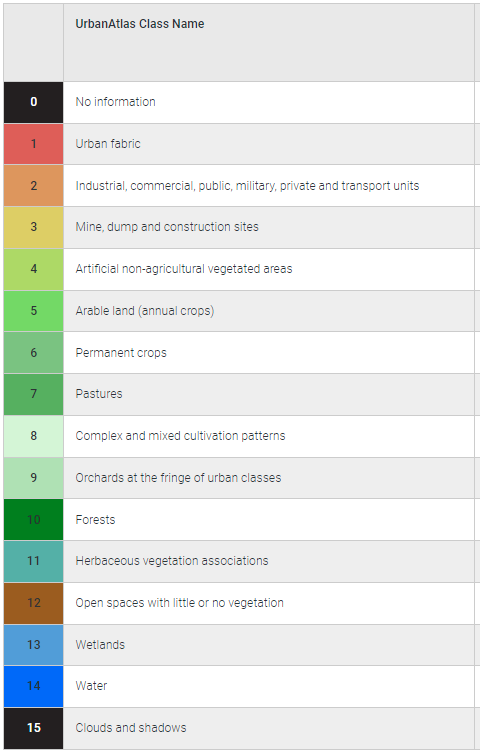

### Validation of Object-Oriented Approach

In [241]:
#Validation of the object-oriented approach
validation_geobia = final_bands.select(predictionBands).sampleRegions(
    **{
        'collection': valpnts,
        'properties': ['b1'],
        'scale': scale,
        'tileScale':8
    })

classificazione = validation_geobia.classify(classifier_OO)

val_CM = classificazione.errorMatrix('b1', 'classification')
# print(type(test_CM)) # <class 'ee.ConfusionMatrix'>
OA_OO = round(val_CM.accuracy().getInfo(),4)
print('Object-Oriented approach: Overall Accuracy =', OA_OO)

Object-Oriented approach: Overall Accuracy = 0.6706


[[56, 14, 9, 0, 5, 7, 2, 2, 0, 2], [13, 86, 1, 1, 1, 2, 2, 1, 0, 1], [7, 6, 61, 0, 8, 6, 12, 5, 0, 3], [0, 0, 0, 85, 0, 0, 0, 0, 0, 0], [14, 2, 13, 0, 60, 10, 14, 3, 0, 2], [2, 9, 18, 0, 18, 58, 5, 3, 0, 1], [6, 2, 19, 0, 13, 8, 47, 13, 0, 2], [1, 0, 1, 0, 0, 1, 6, 88, 0, 8], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 1, 1, 1, 0, 0, 86]]


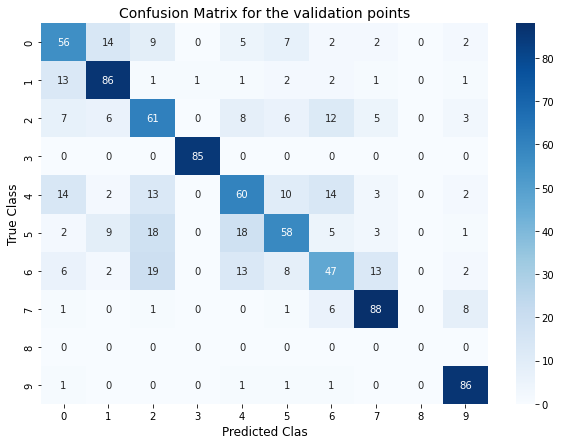

In [242]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

list_val_CM = val_CM.getInfo() # confusion matrix to list
# print(type(test_CM)) # <class 'list'>
print(list_val_CM)

df_cm = pd.DataFrame(list_val_CM, index = [i for i in range(10)],
                  columns = [i for i in range(10)])
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix for the validation points',fontsize=14)
ax = sn.heatmap(df_cm, annot=True,cmap='Blues')
ax.set_xlabel("Predicted Clas", fontsize=12)
ax.set_ylabel("True Class", fontsize=12)
plt.show()

In [243]:
# IoU from CM
OO_val_ious = {}
np_val_CM = np.array(val_CM.getInfo())
for i in range(num_classes):
    OO_val_ious[i] = (class_IoU(i,np_val_CM))
print(OO_val_ious)

{0: 0.3972, 1: 0.6099, 2: 0.3609, 3: 0.9884, 4: 0.3659, 5: 0.3893, 6: 0.3092, 7: 0.6667, 8: 0, 9: 0.789}


Mean IoU from validation points.

In [244]:
# loop to sum all values 
total = 0
number_of_classes = 0
for val in OO_val_ious.values():
    if val != 0:
        number_of_classes += 1
        total += val
print('number_of_classes:', number_of_classes) # 10 if all classes are present
# using len() to get total keys for mean computation
OO_val_miou = round(total / number_of_classes,4)
print('val_miou:', OO_val_miou)

number_of_classes: 9
val_miou: 0.5418


Compare to performance on training dataset

In [ ]:
training_geobia = final_bands.select(predictionBands).sampleRegions(
    **{
        'collection': newfc,
        'properties': ['b1'],
        'scale': scale,
        'tileScale':8
    })

classificazione = training_geobia.classify(classifier_OO)

train_CM = classificazione.errorMatrix('b1', 'classification')
OA_OO_train = round(train_CM.accuracy().getInfo(),4)
print('Object-Oriented approach: Overall Accuracy of training data =', OA_OO_train)
train_CM = train_CM.getInfo()

df_cm = pd.DataFrame(train_CM, index = [i for i in range(10)],
                  columns = [i for i in range(10)])
plt.figure(figsize = (10,7))
plt.title('Confusion Matrix for the training points',fontsize=14)
ax = sn.heatmap(df_cm, annot=True,cmap='Blues')
ax.set_xlabel("Predicted Clas", fontsize=12)
ax.set_ylabel("True Class", fontsize=12)
plt.show()

Print the number of pixel for each class in the final classified image

In [ ]:
# analysis_image_sl = classy_RF.select("classification")

# class0 = analysis_image_sl.updateMask(analysis_image_sl.eq(0)).rename('class00')
# class1 =  analysis_image_sl.updateMask(analysis_image_sl.eq(1)).rename('class01')
# class2 =  analysis_image_sl.updateMask(analysis_image_sl.eq(2)).rename('class02')
# class3 =  analysis_image_sl.updateMask(analysis_image_sl.eq(3)).rename('class03')
# class4 =  analysis_image_sl.updateMask(analysis_image_sl.eq(4)).rename('class04')
# class5 =  analysis_image_sl.updateMask(analysis_image_sl.eq(5)).rename('class05')
# class6 =  analysis_image_sl.updateMask(analysis_image_sl.eq(6)).rename('class06')
# class7 =  analysis_image_sl.updateMask(analysis_image_sl.eq(7)).rename('class07')
# class8 =  analysis_image_sl.updateMask(analysis_image_sl.eq(8)).rename('class08')
# class9 =  analysis_image_sl.updateMask(analysis_image_sl.eq(9)).rename('class09')
# class10 =  analysis_image_sl.updateMask(analysis_image_sl.eq(10)).rename('class10')
# class11 =  analysis_image_sl.updateMask(analysis_image_sl.eq(11)).rename('class11')
# class12 =  analysis_image_sl.updateMask(analysis_image_sl.eq(12)).rename('class12')
# class13 =  analysis_image_sl.updateMask(analysis_image_sl.eq(13)).rename('class13')
# class14 =  analysis_image_sl.updateMask(analysis_image_sl.eq(14)).rename('class14')

# all_classes = class0.addBands(class1).addBands(class2).addBands(class3).addBands(class4) \
#           .addBands(class5).addBands(class6).addBands(class7).addBands(class8).addBands(class9) \
# #             .addBands(class10).addBands(class11).addBands(class12).addBands(class13).addBands(class14)

# count_pixels = all_classes.reduceRegion(
#     **{
#         'reducer': ee.Reducer.count(),
#          'geometry': Area_Nice,
#         'scale':10,
#         'maxPixels': 1e16,
#         'tileScale':8
#     })

# print(count_pixels.getInfo())

Relative importance histogram

In [37]:
#Compute RF variable importance
OO_explained = classifier_OO.explain()
# print("classifier information:", OO_explained.getInfo()) # too large
variableImportance = ee.Feature(None, ee.Dictionary(OO_explained).get('importance'))
variableImportance_dict = variableImportance.getInfo()['properties']
print(variableImportance_dict)

{'B11_mean': 3047.4442975317834, 'B12_mean': 3072.345868151391, 'B2_mean': 2881.309382462477, 'B3_mean': 2833.6510553045364, 'B4_mean': 2857.562942060334, 'B5_mean': 2939.5384047436523, 'B6_mean': 2765.1798972902557, 'B7_mean': 2720.8267421783908, 'B8A_mean': 2747.663541898973, 'B8_mean': 2750.9238671669864}


In [ ]:
vi_list_OO = sorted(variableImportance_dict, key=variableImportance_dict.get)
vi_list_OO.reverse()
print(vi_list_OO)

In [ ]:
fig, ax = plt.subplots(figsize=(18,5))

ax.bar(*zip(*variableImportance_dict.items()))

plt.xticks(range(len(variableImportance_dict)), list(variableImportance_dict.keys()),rotation = 45)

plt.title('Relative importance histogram OO method',fontsize=14)
# ax.set_xlabel("Bands", fontsize=12)
ax.set_ylabel("Importance", fontsize=12)
ax.set_ylim(min(variableImportance_dict.values())-10, max(variableImportance_dict.values())+10)

plt.show()

## Pixel-Based Approach

Selecting the desired bands.

In [ ]:
# #Selecting all input bands
bands = dataset.bandNames()
print(bands.getInfo())

In [119]:
#Selecting desired bands
bands = ['b1_R', 'b2_G', 'b3_B',
         'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 
         'NDVI_MAX', 'NDVI', 'NDVI_STD', 
         'NMDI_MAX', 'NMDI', 'NMDI_STD',
         'BSI_MAX', 'BSI', 'BSI_STD', 
         'EVI_MAX', 'EVI', 'EVI_STD',
         'GRVI_MAX', 'GRVI', 'GRVI_STD', 
         'SMMI_MAX', 'SMMI', 'SMMI_STD', 
         'NDBI_MAX', 'NDBI', 'NDBI_STD', 
         'MNDWI_MAX', 'MNDWI', 'MNDWI_STD',
         # temporal analysis
         'HUE_BSI', 'SAT_BSI', 'VAL_BSI', 
         'HUE_GRVI', 'SAT_GRVI', 'VAL_GRVI'
         'HUE_NDVI', 'SAT_NDVI', 'VAL_NDVI',
         'HUE_NMDI', 'SAT_NMDI', 'VAL_NMDI', 
         'HUE_NDBI', 'SAT_NDBI', 'VAL_NDBI',
        ]
bands = [ 
         'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 
    
        ]

In [120]:
# training dataset

#To improve the amount of supervised information, a buffer with a fixed radius (10 m) is created around each point.
def buffer(feature):
    return feature.buffer(40)

# Get the predictors into the table and create a training dataset based on "b1" property
training = dataset.select(bands).sampleRegions(
    **{
        'collection': newfc.map(buffer),
        'properties': ['b1'],
        'scale': 30,
        'tileScale':8
    })

In [ ]:
'''
//If you decided to use the SVM algorithm it's mandatory the normalization of the input bands
if(classifier_alg =="SVM"){
var image = ee.Image(dataset);
// calculate the min and max value of an image
var minMax = image.reduceRegion({
  reducer: ee.Reducer.minMax(),
  geometry: roi,
  scale: scale,
  maxPixels: 10e16,
}); 
// use unit scale to normalize the pixel values
var dataset = ee.ImageCollection.fromImages(
  image.bandNames().map(function(name){
    name = ee.String(name);
    var band = image.select(name);
    return band.unitScale(ee.Number(minMax.get(name.cat('_min'))), ee.Number(minMax.get(name.cat('_max'))))
})).toBands().rename(image.bandNames());
}
'''

### Training the Classifier

In the PB classification stage, the image is quickly classified by a preliminary definition of the RF
classifier, or the SVM classifier, and the subsequent training phase. As generally performed, a band normalization of the input dataset was applied before applying the SVM classification. For the RF classifier, the number of trees was set to 50, while for the SVM a radial basis function kernel (RBF) was applied (with gamma = 1 and cost = 10). To clean up all the output and reduce the “salt and pepper” effect, a final morphological operation (based on a focal mode) is performed on the output classification

In [74]:
#if you want use RandomForest (classifier_alg= "RF") else use SVM (classifier_alg= "SVM")
classifier_alg = "RF"

In [121]:
#Training a Random Forest Classifier
if classifier_alg == "RF":
    classifier =  ee.Classifier.smileRandomForest(25).train(
        **{
        'features': training,
        'classProperty': 'b1',
        'inputProperties': bands
        })

elif classifier_alg == "SVM":
    classifier = ee.Classifier.libsvm(
        **{
        'kernelType': 'RBF',
        'gamma': 15,
        'cost': 20
        })
    classifier = classifier.train(training, 'b1', bands)

else:
    print("You need to set your classifier for the Pixel Based approach")

classifier_PB = classifier
print('training finished')

training finished


### Classifying

In [132]:
#Clip and filter the result of pixel classification
print(bands) # ['b1', 'b2', 'b3', 'B5', 'B7', 'B8', 'B12', 'NDBI_MAX', 'NDBI_STD', 'NDBI', 'B2']
# print(dataset.bandNames().getInfo()) # ['b1', 'b2', 'b3', 'B5', 'B7', 'B8', 'B12', 'NDBI_MAX', 'NDBI_STD', 'NDBI', 'B2']

classified = dataset.select(bands).classify(classifier_PB).clip(Area_Nice).focal_mode(3)
# Image.focalMode(radius = 1.5, kernelType = 'circle', units = 'pixels', iterations = 1, kernel = null)
# classified = dataset.select(bands).classify(classifier_PB).focal_mode()

# print(classified.bandNames().getInfo()) # ['classification']

['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']


Visualizing and comparing the Pixel-Based classification with the ground truth labels.

In [133]:
Map = geemap.Map()
Map.center_object(roi_tile_2)

# labels
Nice = ee.ImageCollection("users/andreanascetti/IEEE/Nice_Labels")

palette_labels = [
  '000000',
  'FF5733', #(0)  Urban fabric
  'FF5733', #(1)  Industrial, commercial, public, military, private and transport units
  'FF5733', #(2)  Mine, dump and construction sites
  'B7E603', #(3)  Artificial non-agricultural vegetated areas
  'B6FF45', #(4)  Arable land (annual crops)
  '5FB331', #(5)  Permanent crops
  '3FAF17', #(6)  Pastures
  'FCE5CD', #()complex and mixed...
  'C6ECB6', #()orchards at the fringe
  '237605', #(7)  Forests
  '43B680', #(8)  Herbaceous vegetation associations
  '9B621A', #(9)  Open spaces with little or no vegetation
  '0691C3', #(10)  Wetlands
  '085CB8', #(11)  Water
  '000000',
]

# Map.addLayer(Nice.mosaic(),{'min':0, 'max':15, 'palette':palette_labels},"Labels Nice")
left_layer = geemap.ee_tile_layer(Nice.mosaic(), {'min':0, 'max':15, 'palette':palette_labels}, 'Labels') # convert dataset to tile layer

# classification
palette = [
  'FF5733', #(0)  Urban fabric
#   'F98A04', #(1)  Industrial, commercial, public, military, private and transport units
#   'FBDB10', #(2)  Mine, dump and construction sites
  'B7E603', #(3)  Artificial non-agricultural vegetated areas
  'B6FF45', #(4)  Arable land (annual crops)
  '5FB331', #(5)  Permanent crops
  '3FAF17', #(6)  Pastures
#   'FCE5CD', #()complex and mixed...
#   'C6ECB6', #()orchards at the fringe
  '237605', #(7)  Forests
  '43B680', #(8)  Herbaceous vegetation associations
  '9B621A', #(9)  Open spaces with little or no vegetation
  '0691C3', #(10)  Wetlands
  '085CB8', #(11)  Water
]# print(classy_RF.bandNames().getInfo())

# Map.addLayer(classy_RF,{'min':0, 'max':9, 'palette':palette},'classification')
right_layer = geemap.ee_tile_layer(classified, {'min':0, 'max':9, 'palette':palette}, 'classification')


Map.split_map(left_layer, right_layer)
Map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [80]:
#Create the confusion matrix and calculate the overall accuracy on the training data
# print('RF error matrix_training: ', classifier_PB.confusionMatrix())
OA_PB_train = round(classifier_PB.confusionMatrix().accuracy().getInfo(),4)
print('Pixel-Based accuracy of the TRAINING data =', OA_PB_train)

Pixel-Based accuracy of the TRAINING data = 0.8125


### IoU

In [ ]:
# # for each tile
# import tensorflow as tf

# # pred & GT layer in same crs
# classified_reproj = classified.reproject(**{'crs': crs, 'scale': 5})
# # remal the GT labels
# GT_remapped = Nice.mosaic().remap([1,2,3,4,5,6,7,10,11,12,13,14], [0,0,0,1,2,3,4,5,6,7,8,9],15).rename('b1')
# GT_reproj = GT_remapped.reproject(**{'crs': crs, 'scale': 5})

# # print(table1.getInfo().keys()) # dict_keys(['type', 'columns', 'version', 'id', 'properties', 'features'])
# # print((table1.getInfo()['features'])) # list with dictionaries
# # print(len((table1.getInfo()['features']))) # 334
# # print((table1.getInfo()['features'])[0].keys()) # dict_keys(['type', 'geometry', 'id', 'properties'])

# # one big CM
# big_CM = np.zeros((16, 16),dtype=int)
# # print(big_CM)
# # list of all iou dictionaries
# big_iou = []
# # scores = (TP, FP, FN)
# scores_all =[]

# for tile_dict in table1.getInfo()['features']:
#     tile_geom = tile_dict['geometry']
#     tile_geom = ee.Geometry.Polygon(tile_geom['coordinates'],None,False)
#     #print(tile_geom.getInfo())
#     # convert to array
#     # ee_object, bands, region, properties, default_value
#     array_pred = geemap.ee_to_numpy(ee_object = classified_reproj,
#                               region = tile_geom, 
#                               bands = ['classification'],
#                                    default_value = 14)
#     array_GT = geemap.ee_to_numpy(ee_object = GT_reproj,
#                               region = tile_geom,
#                               bands = ['b1'],
#                                  default_value = 15)
#     #print(array_pred)
#     # flatten array
#     flat_pred = array_pred.flatten()
#     flat_GT = array_GT.flatten()
#     present_GT = np.unique(flat_GT)
#     #print(present_GT)
    
#     m = tf.keras.metrics.MeanIoU(num_classes=15+1)
#     m.update_state(flat_GT, flat_pred) # truth, prediciton
#     #print(m.result().numpy()) # mean IoU
#     # confusion matrix
#     tile_CM = np.array(m.get_weights(),dtype=int).reshape(15+1,15+1)
#     #print(tile_CM)
#     # add tile CM to big CM
#     sum_CM = np.add(big_CM,tile_CM)
#     big_CM = sum_CM.copy()
#     #print(big_CM)
    
#    # create iou dictionary for the tile
#     ious = {}
#     for i in present_GT:
#         ious[i] = (class_IoU(i,tile_CM))
#     #print(ious)
#     big_iou.append(ious)
    
#     # TP, FP, FN for each class
#     scores_tile = []
#     for i in range(10):
#         scores_tile.append(TP_FP_FN(i,tile_CM))
#     scores_all.append(scores_tile)
# #     print(scores_tile)
    
# print('finished')
# # output = big_CM (sum of all confusion matrices) & big_iou (list of all iou dictionaries)

In [ ]:
# # TP, FP, FN for each class from big_CM
# scores_big = []
# for i in range(10):
#     scores_big.append(TP_FP_FN(i,big_CM))
# # print(scores_big)

# # get iou per class from TP, FP, FN
# scores_all = np.array(scores_big,dtype = int)
# # print(scores_all)

# iou_all = []
# for TP, FP, FN in scores_all:
#     #print(TP, FP, FN)
#     if TP == 0: 
#         iou_ = 0
#     else: 
#         iou_ = round(TP / (TP + FP + FN),4)
#     #print(iou_)
#     iou_all.append(iou_)
# iou_dict_PB = dict(zip(list(range(16)), iou_all))
# print(iou_dict_PB)
# print('mean IoU over all the tiles:')
# total_mIoU_PB = round(sum(iou_dict_PB.values())/len(iou_dict_PB.values()),4)
# print(total_mIoU_PB)

### Validation of Pixel-Based Approach

In [126]:
#Validation of the pixel-based approach
classifierTest = dataset.select(bands).sampleRegions(**{
    'collection': valpnts,
    'properties': ['b1'],
    'scale': scale,
    'tileScale': 8
})
classified_test_RF = classifierTest.classify(classifier_PB)
PB_val_CM = classified_test_RF.errorMatrix('b1', 'classification')
#print('Pixel approach_Test confusion matrix: ', testAccuracy)
OA_PB = round(PB_val_CM.accuracy().getInfo(),4)
print('PIXEL APPROACH : Overall Accuracy of validation points =', OA_PB)

PIXEL APPROACH : Overall Accuracy of validation points = 0.4642


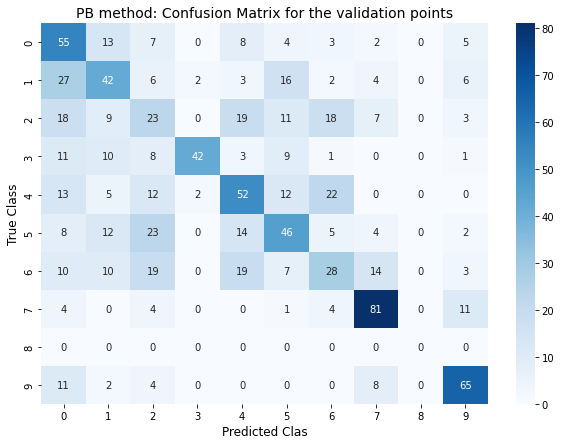

In [127]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(PB_val_CM.getInfo(), index = [i for i in range(10)],
                  columns = [i for i in range(10)])
plt.figure(figsize = (10,7))
plt.title('PB method: Confusion Matrix for the validation points',fontsize=14)
ax = sn.heatmap(df_cm, annot=True,cmap='Blues')
ax.set_xlabel("Predicted Clas", fontsize=12)
ax.set_ylabel("True Class", fontsize=12)
plt.show()

IoU derived from validation Confusion Matrix.

In [128]:
# IoU from CM
PB_val_ious = {}
np_val_CM = np.array(PB_val_CM.getInfo())
for i in range(num_classes):
    PB_val_ious[i] = (class_IoU(i,np_val_CM))
print(PB_val_ious)

{0: 0.2764, 1: 0.2485, 2: 0.1204, 3: 0.4719, 4: 0.2826, 5: 0.2644, 6: 0.1697, 7: 0.5625, 8: 0, 9: 0.5372}


In [129]:
# loop to sum all values 
total = 0
number_of_classes = 0
for val in PB_val_ious.values():
    if val != 0:
        number_of_classes += 1
        total += val
print('number_of_classes:', number_of_classes) # 10 if all classes are present
# using len() to get total keys for mean computation
PB_val_miou = round(total / number_of_classes,4)
print('val_miou:', PB_val_miou)

number_of_classes: 9
val_miou: 0.326


In [ ]:
# #Print the number of pixels for each class
# analysis_image = classified.select("classification")

# class0 = analysis_image_sl.updateMask(analysis_image_sl.eq(0)).rename('class00')
# class1 =  analysis_image_sl.updateMask(analysis_image_sl.eq(1)).rename('class01')
# class2 =  analysis_image_sl.updateMask(analysis_image_sl.eq(2)).rename('class02')
# class3 =  analysis_image_sl.updateMask(analysis_image_sl.eq(3)).rename('class03')
# class4 =  analysis_image_sl.updateMask(analysis_image_sl.eq(4)).rename('class04')
# class5 =  analysis_image_sl.updateMask(analysis_image_sl.eq(5)).rename('class05')
# class6 =  analysis_image_sl.updateMask(analysis_image_sl.eq(6)).rename('class06')
# class7 =  analysis_image_sl.updateMask(analysis_image_sl.eq(7)).rename('class07')
# class8 =  analysis_image_sl.updateMask(analysis_image_sl.eq(8)).rename('class08')
# class9 =  analysis_image_sl.updateMask(analysis_image_sl.eq(9)).rename('class09')
# class10 =  analysis_image_sl.updateMask(analysis_image_sl.eq(10)).rename('class10')
# class11 =  analysis_image_sl.updateMask(analysis_image_sl.eq(11)).rename('class11')
# class12 =  analysis_image_sl.updateMask(analysis_image_sl.eq(12)).rename('class12')
# class13 =  analysis_image_sl.updateMask(analysis_image_sl.eq(13)).rename('class13')
# class14 =  analysis_image_sl.updateMask(analysis_image_sl.eq(14)).rename('class14')

# all_classes = class0.addBands(class1).addBands(class2).addBands(class3).addBands(class4) \
#           .addBands(class5).addBands(class6).addBands(class7).addBands(class8).addBands(class9) \
# #             .addBands(class10).addBands(class11).addBands(class12).addBands(class13).addBands(class14)

# count_pixels = all_classes.reduceRegion(
#     **{
#         'reducer': ee.Reducer.count(),
#          'geometry': Area_Nice,
#         'scale':10,
#         'maxPixels': 1e16,
#         'tileScale':8
#     })

# print(count_pixels.getInfo())

Relative importance histogram

In [85]:
#Compute RF variable importance
PB_explained = classifier_PB.explain()
# print("classifier information:", OO_explained.getInfo()) # too large
variableImportance = ee.Feature(None, ee.Dictionary(PB_explained).get('importance'))
variableImportance_dict = variableImportance.getInfo()['properties']
print(variableImportance_dict)

{'b1_R': 6262.91956416668, 'b2_G': 6087.016121111267, 'b3_B': 6161.906770173094}


In [86]:
# sorted by variable importance
vi_list_PB = sorted(variableImportance_dict, key=variableImportance_dict.get)
vi_list_PB.reverse()
print(vi_list_PB)

['b1_R', 'b3_B', 'b2_G']


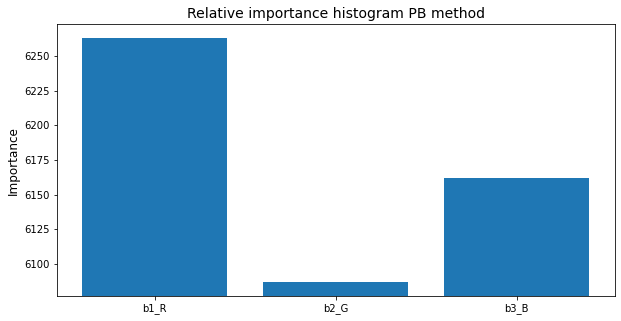

In [88]:
# plot bar chart
fig, ax = plt.subplots(figsize=(10,5)) #18,5))

ax.bar(*zip(*variableImportance_dict.items()))

plt.xticks(range(len(variableImportance_dict)), list(variableImportance_dict.keys()))#,rotation = 45)

plt.title('Relative importance histogram PB method',fontsize=14)
# ax.set_xlabel("Bands", fontsize=12)
ax.set_ylabel("Importance", fontsize=12)
ax.set_ylim(min(variableImportance_dict.values())-10, max(variableImportance_dict.values())+10)

plt.show()

## Comparing OO and PB method

In [ ]:
# Map = geemap.Map()
# Map.center_object(roi_tile)

# palette = [
#   'FF5733', #(0)  Urban fabric
# #   'F98A04', #(1)  Industrial, commercial, public, military, private and transport units
# #   'FBDB10', #(2)  Mine, dump and construction sites
#   'B7E603', #(3)  Artificial non-agricultural vegetated areas
#   'B6FF45', #(4)  Arable land (annual crops)
#   '5FB331', #(5)  Permanent crops
#   '3FAF17', #(6)  Pastures
# #   'FCE5CD', #()complex and mixed...
# #   'C6ECB6', #()orchards at the fringe
#   '237605', #(7)  Forests
#   '43B680', #(8)  Herbaceous vegetation associations
#   '9B621A', #(9)  Open spaces with little or no vegetation
#   '0691C3', #(10)  Wetlands
#   '085CB8', #(11)  Water
# ]# print(classy_RF.bandNames().getInfo())

# left_layer = geemap.ee_tile_layer(classy_RF, {'min':0, 'max':9, 'palette':palette}, 'classification')
# right_layer = geemap.ee_tile_layer(classified, {'min':0, 'max':9, 'palette':palette}, 'classification')

# Map.split_map(left_layer, right_layer)
# Map

# Results

## Writing results

In [ ]:
import os
import csv

path = 'results'
isExist = os.path.exists(path)
if not isExist:
  # Create a new directory 
  os.makedirs(path)
  print("The new directory is created!")

header = ['OA_test', 'OA_train','mIoU','class_iou', 'method', 'classifier', 'snic_scale', 'bandNames']
data = [
    {'OA_test': OA_OO, 'OA_train': OA_OO_train,'mIoU': OO_val_miou,'class_iou': OO_val_ious, 'method': 'OO','classifier': 'RF25_buffer40', 'snic_scale': snic_scale, 'bandNames': vi_list_OO},
    {'OA_test': OA_PB, 'OA_train': OA_PB_train,'mIoU': PB_val_miou,'class_iou': PB_val_ious,  'method': 'PB','classifier': 'RF25_buffer40', 'snic_scale': '/', 'bandNames': vi_list_PB}
]
with open('results/classificationOA_10.csv', 'a+') as file:
    # Create a CSV dictionary writer and add the student header as field names
    writer = csv.DictWriter(file, fieldnames=header)
    # Use writerows() not writerow()
    #writer.writeheader()
    writer.writerows(data)

In [ ]:
df = pd.DataFrame.from_dict(data, dtype=None)
print(df.dtypes)
# df.to_parquet('results/df.parquet.gzip',compression='gzip')  

# out = pd.read_parquet('results/df.parquet.gzip')  
# print(out)

## Viewing results

In [ ]:
import pandas as pd
df = pd.read_csv('results/classificationOA.csv')  
print(df)

In [ ]:
from IPython.display import display

# displaying the DataFrame
display(df)

# Visualizations

In [ ]:
period_of_interest_2017 = ee.Filter.date('2017-01-01', '2019-12-31')
period_of_interest_2015 = ee.Filter.date('2015-01-01', '2016-12-31')

In [ ]:
dataset_2017 = (
    ee.ImageCollection('COPERNICUS/S2_SR') 
    .filterBounds(Area_Nice)
    .filter(period_of_interest_2017)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)) 
    .map(maskS2clouds)
    .select(inBands)#.select(["B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12"])#.select('B2')
)

dataset_2015 = (
    ee.ImageCollection('COPERNICUS/S2_SR') 
    .filterBounds(Area_Nice)
    .filter(period_of_interest_2015)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',10)) 
    .map(maskS2clouds)
    .select(inBands)#.select(["B2","B3","B4","B5","B6","B7","B8","B8A","B11","B12"])#.select('B2')
)

In [ ]:
HR_data = ee.ImageCollection("users/andreanascetti/IEEE/Nice_Ortho").mosaic()

median_2017 = dataset_2017.median()
median_2015 = dataset_2015.median()

Map = geemap.Map()
Map.centerObject(Area_Nice)
Map.addLayer(median_2017, visParams,'median 2017')#{'bands':['B4', 'B3', 'B2']}, 'Median')
Map.addLayer(median_2015, visParams,'median 2015')#{'bands':['B4', 'B3', 'B2']}, 'Median')
Map.addLayer(HR_data,{},'HR_data')
Map.addLayer(Nice.mosaic(),{'min':0, 'max':14, 'palette':palette_labels},"Labels_Nice")
Map